# Predcition of Hospital Admission Related to Upper Respiratory Tract Infection

In this notebook, we develop Cox proportional hazard regression models to predict the risk of hospital admission related to upper respiratory tract infection (URTI).

In [1]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.preprocessing import OneHotEncoder
from datetime import date
from operator import attrgetter
import io
from contextlib import redirect_stdout
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

## 0- functions

In [2]:
# def create_lineplot(data, var, title, legend_title, ax1):
def create_lineplot(data, var, title, ax1):
    a = data.groupby(['date', var]).size().reset_index()
    a.columns = ['date', var, 'Freq']
    # a.Freq = a.Freq*1000
    a = a[a.Freq > 5]
    sns.lineplot(x='date', y='Freq', 
            hue=var, 
            data=a,
            ax=ax1)
    ax1.set_title(title)
    ax1.set_ylabel('Count')
    ax1.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=90)
#     ax1.legend(title=legend_title)
    # ax1.grid()
    ax1.axvline(x="2020-01", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2020-04", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2021-04", color='black', ls='--', lw=1.5)

In [3]:
# function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [4]:
def round_five_mul(x, base=5):
    return base * round(x/base)

In [5]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking_status', 'bmi', 'imd', 'ethnicity', 
                   'region', 'CCI', 'died_date', 'deregistered_date', 'practice', 
                   'antibacterial_brit_'+str(i), 'urti_date_'+str(i), 'urti_ab_date_'+str(i), 'urti_ab_type_'+str(i),
                   'incdt_urti_date_'+str(i), 'admitted_urti_date_'+str(i), 'sgss_gp_cov_urti_date_'+str(i)]]
    
    #drop rows with no urti reord
    datum = datum[datum['urti_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with urti_i
    datum = datum[datum['sgss_gp_cov_urti_date_'+str(i)] == 0]
    #rename variables with i
    datum.rename(columns={'urti_date_'+str(i): 'urti_date', 'urti_ab_date_'+str(i): 'urti_ab_date', 
                           'urti_ab_type_'+str(i): 'ab_type', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'incdt_urti_date_'+str(i): 'incdt_urti_date', 'incdt_urti_type_'+str(i): 'incdt_urti_type',
                           'admitted_urti_date_'+str(i): 'admitted_urti_date',
                           'sgss_gp_cov_urti_date_'+str(i): 'sgss_gp_cov_urti_date'},
                inplace=True)
    
    return datum

In [6]:
def cox_data_prep(data, vars, vars_countinuous, vars_output):
    # data_req = data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit',
    #              'event_urti_admitted', 'duration_urti_admitted']]
    data_req = data[vars+vars_countinuous+vars_output]

    # encoding categorical data for CPH
    # data_enc = data_req[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit']].reset_index()
    data_enc = data_req[vars+vars_countinuous].reset_index()
    # data_enc

    # creating instance of one-hot-encoder
    enc = OneHotEncoder()
    results = enc.fit_transform(data_enc)
    data_req_enc = pd.DataFrame(enc.fit_transform(data_enc[vars]).toarray())
    data_req_enc.columns = enc.get_feature_names(data_enc[vars].columns)
    data_req_enc = data_enc[vars_countinuous].join(data_req_enc) 

    return data_req, data_req_enc

In [7]:
def make_summary_table(infection, infection_type, data):
    #summary table
    summary_table = data.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = data.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = data.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'
    # summary_table

    # save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'.csv', index=False)

In [8]:
def make_summary_table_hosped(infection, infection_type, data):
    #keep hospitalised cses (events=1)
    data_hosped = data[data['event_'+infection+'_admitted'] == 1]

    # encoding categorical hosped data
    data_hosped = data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit']].reset_index()
    # data_hosped

    # creating instance of one-hot-encoder
    enc = OneHotEncoder()
    results = enc.fit_transform(data_hosped)
    data_hosped_enc = pd.DataFrame(enc.fit_transform(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season']]).toarray())
    data_hosped_enc.columns = enc.get_feature_names(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season']].columns)
    data_hosped_enc = data_hosped[['antibacterial_brit']].join(data_hosped_enc)

    # data_hosped_enc#.head()
    #summary table for hosped cases
    summary_table_hosped = data_hosped_enc.sum(axis=0).reset_index()
    summary_table_hosped.columns = ['variable', 'count']
    summary_table_hosped['mean'] = data_hosped_enc.mean(axis=0).reset_index()[0]
    #round count to make last digit either 0 or 5
    summary_table_hosped['count'] = round_five_mul(summary_table_hosped['count'], base=5)
    summary_table_hosped['std'] = data_hosped_enc.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table_hosped.loc[(summary_table_hosped['count'] <= 5), 'count'] = 'SM'
    # summary_table_hosped

    # save table
    summary_table_hosped.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'_hosped.csv', index=False)

In [9]:
def cox_model_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    return cph, data_train, data_test

In [10]:
def betas_sumbetas_calculate(cph, directory, betas_name, data_infection_enc, data_infection, sum_betas_name):
    # cleaning up covariates to make them compatible with the encoded data
    covariates = cph.params_.reset_index()#.hazard_ratios_
    covariates.covariate = covariates.covariate.str.replace("[","")
    covariates.covariate = covariates.covariate.str.replace("]","")
    covariates.covariate = covariates.covariate.str.replace("T.","_")
    # covariates.shape

    # save coefficients
    covariates.to_csv(directory+betas_name, index=False)

    # transpose and sort covariates and coefficients
    covariatesT = covariates.T
    # covariatesT.covariate = covariates
    header = covariatesT.iloc[0]
    covariatesT = covariatesT[1:]
    covariatesT.columns = header
    covariatesT = covariatesT.sort_index(axis = 1) #sort covariates to match data
    # covariatesT.shape

    # further cleaning up covariates to make them compatible with the encoded data
    mylist = ["'" + item + "'" for item in covariates.covariate] #adds single quotation mark
    mylist = [value.replace("'", "") for value in mylist] #removes double quotation mark 

    #match mylist (covariates of cox model) with encoded data
    data = data_infection_enc[data_infection_enc.columns.intersection(mylist)] 
    data = data.sort_index(axis = 1) #sort 
    # data.shape

    # multiply betas and encoded data
    betas = data.multiply(np.array(covariatesT), axis='columns')
    # betas

    # sum up betas of each row to calculate sum of betas 
    sum_betas = betas.sum(axis=1)
    # sum_betas
#######################################################
    # predict cumulative hazard values at day 30 and match them with sum of betas
    sum_betas_hazard = cph.predict_cumulative_hazard(data_infection).loc[[30]].T.reset_index(drop=True)
    sum_betas_hazard['sum_betas'] = sum_betas
    # sum_betas_hazard

    #drop rows with predicted risks greater than 99th percentile of all risks
    sum_betas_hazard = sum_betas_hazard[sum_betas_hazard[30] <= sum_betas_hazard[30].quantile(0.99)]  
    # return sum_betas_hazard

    # sort values of sum of betas
    sum_betas_hazard = sum_betas_hazard.sort_values(by=['sum_betas'])
    # sum_betas_hazard

    # binning sum of betas into 100 bins
    sum_betas_hazard['bins'] = pd.cut(sum_betas_hazard['sum_betas'], 100) #100 intervals between min and max of sum_betas
    # sum_betas_hazard

    #calculate mean of cumulative hazar at day 30 by groupby 
    sum_betas_hazard_groupby = sum_betas_hazard.groupby(['bins'])[30.0].describe().reset_index()
    # sum_betas_hazard_groupby

    #calculate interpolation of missing mean values 
    sum_betas_hazard_groupby['mean_interpolate'] = sum_betas_hazard_groupby['mean'].interpolate(method='linear')

    # separate upper and lower boundries of bins
    sum_betas_hazard_groupby['bin_lower'] = sum_betas_hazard_groupby['bins'].map(attrgetter('left'))
    sum_betas_hazard_groupby['bin_upper'] = sum_betas_hazard_groupby['bins'].map(attrgetter('right'))
    # sum_betas_hazard_groupby.head()

    # select relevant columns including mean of cumulative hazard for each bin and the interpolation of means of cumulative hazard
    sum_betas = sum_betas_hazard_groupby[['bin_lower', 'bin_upper', 'mean_interpolate']]

    # save relevant columns of sum_betas
    sum_betas.to_csv(directory+sum_betas_name, index=False)

In [11]:
def cph_roc_curve(cph, event_col_name, data_train, data_test, directory, roc_name):
    # analysis of discrimination (training) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_train_cumulative_hazard = cph.predict_cumulative_hazard(data_train)
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.loc[[30]].T
    cph_train_cumulative_hazard[event_col_name] = data_train[event_col_name]
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)
    # cph_train_cumulative_hazard

    # analysis of discrimination (testing) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_test_cumulative_hazard = cph.predict_cumulative_hazard(data_test)
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.loc[[30]].T
    cph_test_cumulative_hazard[event_col_name] = data_test[event_col_name]
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)
    # cph_test_cumulative_hazard

    # plot roc curves
    r_fpr1, r_tpr1, _ = roc_curve(cph_train_cumulative_hazard[event_col_name], cph_train_cumulative_hazard.cumulative_hazard)
    r_fpr2, r_tpr2, _ = roc_curve(cph_test_cumulative_hazard[event_col_name], cph_test_cumulative_hazard.cumulative_hazard)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='Cox with development data')
    line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='Cox with validation data')

    squares = [0,1.01]
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)

    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=14)
    # plt.title('', fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    # plt.tight_layout()
    plt.savefig(directory+'/'+roc_name, bbox_inches='tight')
    plt.show()

In [12]:
def cph_calibration(cph, data_train, event_name, data_test, directory, calib_train_name, calib_test_name):
    #predict cumulative hazard in day 30
    prob_pred_true_train = cph.predict_cumulative_hazard(data_train).loc[[30]].T
    prob_pred_true_train.columns = ['pred']
    # prob_pred_true_train

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_train['bins'] = pd.qcut(prob_pred_true_train['pred'], 10)
    # prob_pred_true_train

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_train = pd.merge(prob_pred_true_train, data_train[event_name], left_index=True, right_index=True)
    # prob_pred_true_train

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_train_groupby_bin = prob_pred_true_train.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_train_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']
    # prob_pred_true_train_groupby_bin

    #calculate proportion of events in each bin
    prob_pred_true_train_groupby_bin['event_proportion'] = prob_pred_true_train_groupby_bin['event_sum']/prob_pred_true_train_groupby_bin['event_count']
    # prob_pred_true_train_groupby_bin
############
    #predict cumulative hazard in day 30
    prob_pred_true_test = cph.predict_cumulative_hazard(data_test).loc[[30]].T #[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit', 'gp_count']]).loc[[30]].T#.reset_index(drop=True)
    prob_pred_true_test.columns = ['pred']

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_test['bins'] = pd.qcut(prob_pred_true_test['pred'], 10)

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_test = pd.merge(prob_pred_true_test, data_test[event_name], left_index=True, right_index=True)

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_test_groupby_bin = prob_pred_true_test.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_test_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

    #calculate proportion of events in each bin
    prob_pred_true_test_groupby_bin['event_proportion'] = prob_pred_true_test_groupby_bin['event_sum']/prob_pred_true_test_groupby_bin['event_count']
    # prob_pred_true_test_groupby_bin
###################
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_train_groupby_bin.pred_mean, prob_pred_true_train_groupby_bin.event_proportion, marker='o', facecolors='none', edgecolors='g', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    # plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_train_name, bbox_inches='tight')
    plt.show()

    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_test_groupby_bin.pred_mean, prob_pred_true_test_groupby_bin.event_proportion, marker='v', facecolors='none', edgecolors='y', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    # plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_test_name, bbox_inches='tight')
    plt.show()

In [13]:
def cph_output(cph, infection, infection_type, data_train, data_test, event_name, duration_name, directory):
    # calculate concordance index, AUROC, and Brier score of cph model
    concord_index_train = concordance_index(data_train[duration_name], -cph.predict_partial_hazard(data_train), data_train[event_name])
    concord_index_test = concordance_index(data_test[duration_name], -cph.predict_partial_hazard(data_test), data_test[event_name])
    
    # save model outputs
    a = open(directory+'cph_'+infection+'_'+infection_type+'_output.txt', "w")
    a.write("")
    a.writelines(['Concordance index for '+infection+'_'+infection_type+' with development data: %.4f' % (concord_index_train), 
                '\nConcordance index for '+infection+'_'+infection_type+' with validation data: %.4f' % (concord_index_test)])

In [14]:
def cox_model_abs_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + urti_ab_date"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    return cph, data_train, data_test

In [15]:
def cox_model_ab_type_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + ab_type_cat"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    return cph, data_train, data_test

In [16]:
def cox_model_strat_sex_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + urti_ab_date"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    return cph, data_train, data_test

In [17]:
def cox_model_strat_age_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + urti_ab_date"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    return cph, data_train, data_test

## 1- data preparation

In [18]:
data = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_urti.csv.gz')

data.shape

(200000, 224)

In [19]:
# save model outputs
a = open("../output/hospitalisation_prediction_urti/data_urti_record_cph_urti.txt", "w")
a.write("")
a.writelines(['data_urti_1 #with a record, #with no record: %.0f' % (data['urti_date_1'].notna().sum()), ', %.0f' % (data['urti_date_1'].isna().sum()),
              '\ndata_urti_2 #with a record, #with no record: %.0f' % (data['urti_date_2'].notna().sum()), ', %.0f' % (data['urti_date_2'].isna().sum()),
              '\ndata_urti_3 #with a record, #with no record: %.0f' % (data['urti_date_3'].notna().sum()), ', %.0f' % (data['urti_date_3'].isna().sum()),
              '\ndata_urti_4 #with a record, #with no record: %.0f' % (data['urti_date_4'].notna().sum()), ', %.0f' % (data['urti_date_4'].isna().sum()),
              '\ndata_urti_5 #with a record, #with no record: %.0f' % (data['urti_date_5'].notna().sum()), ', %.0f' % (data['urti_date_5'].isna().sum()),
              '\ndata_urti_6 #with a record, #with no record: %.0f' % (data['urti_date_6'].notna().sum()), ', %.0f' % (data['urti_date_6'].isna().sum()),
              '\ndata_urti_7 #with a record, #with no record: %.0f' % (data['urti_date_7'].notna().sum()), ', %.0f' % (data['urti_date_7'].isna().sum()),
              '\ndata_urti_8 #with a record, #with no record: %.0f' % (data['urti_date_8'].notna().sum()), ', %.0f' % (data['urti_date_8'].isna().sum()),
              '\ndata_urti_9 #with a record, #with no record: %.0f' % (data['urti_date_9'].notna().sum()), ', %.0f' % (data['urti_date_9'].isna().sum()),
              '\ndata_urti_10 #with a record, #with no record: %.0f' % (data['urti_date_10'].notna().sum()), ', %.0f' % (data['urti_date_10'].isna().sum()),
              '\ndata_urti_11 #with a record, #with no record: %.0f' % (data['urti_date_11'].notna().sum()), ', %.0f' % (data['urti_date_11'].isna().sum()),
              '\ndata_urti_12 #with a record, #with no record: %.0f' % (data['urti_date_12'].notna().sum()), ', %.0f' % (data['urti_date_12'].isna().sum()),
              '\ndata_urti_13 #with a record, #with no record: %.0f' % (data['urti_date_13'].notna().sum()), ', %.0f' % (data['urti_date_13'].isna().sum()),
              '\ndata_urti_14 #with a record, #with no record: %.0f' % (data['urti_date_14'].notna().sum()), ', %.0f' % (data['urti_date_14'].isna().sum()),
              '\ndata_urti_15 #with a record, #with no record: %.0f' % (data['urti_date_15'].notna().sum()), ', %.0f' % (data['urti_date_15'].isna().sum()),
              '\ndata_urti_16 #with a record, #with no record: %.0f' % (data['urti_date_16'].notna().sum()), ', %.0f' % (data['urti_date_16'].isna().sum()),
              '\ndata_urti_17 #with a record, #with no record: %.0f' % (data['urti_date_17'].notna().sum()), ', %.0f' % (data['urti_date_17'].isna().sum()),
              '\ndata_urti_18 #with a record, #with no record: %.0f' % (data['urti_date_18'].notna().sum()), ', %.0f' % (data['urti_date_18'].isna().sum()),
              '\ndata_urti_19 #with a record, #with no record: %.0f' % (data['urti_date_19'].notna().sum()), ', %.0f' % (data['urti_date_19'].isna().sum()),
              '\ndata_urti_20 #with a record, #with no record: %.0f' % (data['urti_date_20'].notna().sum()), ', %.0f' % (data['urti_date_20'].isna().sum()),
              ])

### 1-2- additional variables
Calculating Charlson Comorbidity Index based on https://www.nature.com/articles/4500889.pdf?origin=ppub

In [20]:
data['CCI'] = np.nan
col0 = data.columns.get_loc('CCI')

col1 = data.columns.get_loc('cancer_comor')
col2 = data.columns.get_loc('cardiovascular_comor')
col3 = data.columns.get_loc('chronic_obstructive_pulmonary_comor') ##
col4 = data.columns.get_loc('heart_failure_comor') ##
col5 = data.columns.get_loc('connective_tissue_comor')
col6 = data.columns.get_loc('dementia_comor')
col7 = data.columns.get_loc('diabetes_comor')
col8 = data.columns.get_loc('diabetes_complications_comor')
col9 = data.columns.get_loc('hemiplegia_comor')
col10 = data.columns.get_loc('hiv_comor')
col11 = data.columns.get_loc('metastatic_cancer_comor')
col12 = data.columns.get_loc('mild_liver_comor')
col13 = data.columns.get_loc('mod_severe_liver_comor')
col14 = data.columns.get_loc('mod_severe_renal_comor')
col15 = data.columns.get_loc('mi_comor')
col16 = data.columns.get_loc('peptic_ulcer_comor')
col17 = data.columns.get_loc('peripheral_vascular_comor')


for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, col15] == 1: # mi_comor
        n=n+1
    if data.iat[idx, col2] == 1: # cardiovascular_comor
        n=n+1 
    if data.iat[idx, col17] == 1: # peripheral_vascular_comor
        n=n+1 
    if data.iat[idx, col3] == 1: # chronic_obstructive_pulmonary_comor
        n=n+1
    if data.iat[idx, col7] == 1: # diabetes_comor
        n=n+1
    if data.iat[idx, col6] == 1: # dementia_comor
        n=n+1
    if data.iat[idx, col16] == 1: # peptic_ulcer_comor
        n=n+1
    if data.iat[idx, col5] == 1: # connective_tissue_comor
        n=n+1
    if data.iat[idx, col12] == 1: # mild_liver_comor
        n=n+1
    if data.iat[idx, col9] == 1: # hemiplegia_comor
        n=n+2
    if data.iat[idx, col14] == 1: # mod_severe_renal_comor
        n=n+2
    if data.iat[idx, col8] == 1: # diabetes_complications_comor
        n=n+2
    if data.iat[idx, col1] == 1: # cancer_comor
        n=n+2
    if data.iat[idx, col13] == 1: # mod_severe_liver_comor
        n=n+3
    if data.iat[idx, col11] == 1: # metastatic_cancer_comor
        n=n+6
    if data.iat[idx, col10] == 1: # hiv_comor
        n=n+6
    
    data.iat[idx, col0]=n

data.CCI.value_counts()

0.0     37177
1.0     37100
2.0     32753
3.0     24898
4.0     14980
6.0     12289
7.0      9833
5.0      8441
8.0      7918
9.0      5726
10.0     3380
11.0     1865
12.0     1407
13.0      878
14.0      581
15.0      370
16.0      193
17.0      117
18.0       51
19.0       26
20.0       12
21.0        4
22.0        1
Name: CCI, dtype: int64

## 2- data preparation
This includes data type conversion and exclusion of cases that are not considered in the infection-related hospital admission, i.e. those who were diagnosed with Covid19 three months (=90 days) before and one month (=30 days) after hospital admission.

### 2-1- gathering data

In [21]:
#read 12 urtis and concatenate them 
data_urti_1 = proc_infec_data(data,1)
data_urti_2 = proc_infec_data(data,2)
data_urti_3 = proc_infec_data(data,3)
data_urti_4 = proc_infec_data(data,4)
data_urti_5 = proc_infec_data(data,5)
data_urti_6 = proc_infec_data(data,6)
data_urti_7 = proc_infec_data(data,7)
data_urti_8 = proc_infec_data(data,8)
data_urti_9 = proc_infec_data(data,9)
data_urti_10 = proc_infec_data(data,10)
data_urti_11 = proc_infec_data(data,11)
data_urti_12 = proc_infec_data(data,12)

data_urti = pd.concat([data_urti_1, data_urti_2, data_urti_3, data_urti_4, data_urti_5, data_urti_6, data_urti_7, data_urti_8, data_urti_9, data_urti_10, data_urti_11, data_urti_12])
data_urti.reset_index(inplace=True, drop=True)
data_urti.shape

(216129, 20)

### 2-2- add season, event, and duration variables
#### season

In [22]:
# convert data types
data_urti['urti_date'] = data_urti['urti_date'].astype('datetime64[ns]')
data_urti['admitted_urti_date'] = data_urti['admitted_urti_date'].astype('datetime64[ns]')
data_urti.died_date = data_urti.died_date.astype('datetime64[ns]')
data_urti.deregistered_date = data_urti.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_urti['date'] = data_urti['urti_date'] #gp_cons_urti
data_urti['date'] = data_urti['date'].dt.strftime('%Y-%m')
print(f'min date: {data_urti.date.min()}')
print(f'max date: {data_urti.date.max()}')
print(f'length of data_urti: {len(data_urti)}')

min date: 2019-01
max date: 2022-11
length of data_urti: 216129


In [23]:
#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')
# today_date_y_m

#drop any records of data_urti with today's date in year and month
data_urti = data_urti[data_urti['date'] != today_date_y_m]

#get two months before today's date in year and month 
last_1_month_date_y_m = date.today() - pd.DateOffset(months=1)
last_1_month_date_y_m = last_1_month_date_y_m.strftime('%Y-%m')
last_2_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_2_month_date_y_m = last_2_month_date_y_m.strftime('%Y-%m')
#drop any record of data with two month before today's date in year and month
data_urti = data_urti[data_urti['date'] != last_1_month_date_y_m]
data_urti = data_urti[data_urti['date'] != last_2_month_date_y_m]

#add a variable called season based on the month of urti records
data_urti['season'] = np.nan
data_urti['date_month'] = pd.DatetimeIndex(data_urti['date']).month

conditions = [
    (data_urti['date_month'] >= 3) & (data_urti['date_month'] <= 5),
    (data_urti['date_month'] >= 6) & (data_urti['date_month'] <= 8),
    (data_urti['date_month'] >= 9) & (data_urti['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_urti['season'] = np.select(conditions, choices, default='winter')

print(data_urti['season'].value_counts())
print(f'\nmin date: {data_urti.date.min()}')
print(f'max date: {data_urti.date.max()}')
print(f'length: {len(data_urti)}')

spring    56282
summer    56210
winter    50197
autumn    41827
Name: season, dtype: int64

min date: 2019-01
max date: 2022-08
length: 204516


In [24]:
# data_urti = data_urti[data_urti['date'] <= '2019-12']
# data_urti = data_urti[(data_urti['date'] >= '2020-03') & (data_urti['date']<= '2021-03')]
# data_urti = data_urti[data_urti['date'] >= '2021-04']
# print(f'min date: {data_urti.date.min()}')
# print(f'max date: {data_urti.date.max()}')

#### event and duration

In [25]:
#scenario 1
#not hosped (nothing happened)
#data_urti = data_urti[data_urti['admitted_urti_date'].notnull()]
data_urti.loc[data_urti['admitted_urti_date'].isnull(), 'event_urti_admitted'] = 0
data_urti['event_urti_admitted'].value_counts()

0.0    142895
Name: event_urti_admitted, dtype: int64

In [26]:
#scenario 2 
# become a case (uncensoring)
#calculating days between infection gp consultation and hosp
# data_urti['delta_urti_admitted'] = (data_urti['admitted_urti_date'] - data_urti['urti_date']).dt.days
data_urti['delta_urti_admitted'] = (data_urti['admitted_urti_date'] - data_urti['urti_date']).dt.days #gp_cons_urti
data_urti.loc[((data_urti['delta_urti_admitted'] >= 0) & (data_urti['delta_urti_admitted'] <= 30)), 'event_urti_admitted'] = 1
# data_urti['event_urti_admitted'].value_counts()

#scenario 2
#drop whoever was admitted before urti consultation, i.e. negative value for delta_urti_admitted
data_urti = data_urti[~(data_urti['delta_urti_admitted'] < 0)]
data_urti['delta_urti_admitted'].value_counts()

91.0      64
70.0      63
2.0       62
0.0       61
20.0      59
          ..
1367.0     1
1395.0     1
1379.0     1
1335.0     1
1391.0     1
Name: delta_urti_admitted, Length: 1389, dtype: int64

In [27]:
#scenario 3
#censor died patients
data_urti['delta_admitted_died'] = (data_urti['died_date'] - data_urti['admitted_urti_date']).dt.days
data_urti.loc[data_urti['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
# data_urti.loc[data_urti['delta_admitted_died'] >= 0, 'event_urti_admitted'] = 0
data_urti.loc[((data_urti['delta_admitted_died'] >= 0) & (data_urti['delta_admitted_died'] <= 30)), 'event_urti_admitted'] = 0
# data_urti['event_urti_admitted'].value_counts()

#scenario 3
#censor deregistered patients
data_urti['delta_admitted_deregistered'] = (data_urti['deregistered_date'] - data_urti['admitted_urti_date']).dt.days
data_urti.loc[data_urti['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
# data_urti.loc[data_urti['delta_admitted_deregistered'] >= 0, 'event_urti_admitted'] = 0
data_urti.loc[((data_urti['delta_admitted_deregistered'] > 0) & (data_urti['delta_admitted_deregistered'] <= 30)), 'event_urti_admitted'] = 0
# data_urti['event_urti_admitted'].value_counts()

#agg scenario 3s
data_urti['delta_admitted_died_deregistered'] = data_urti['delta_admitted_deregistered'].combine_first(data_urti['delta_admitted_died'])
data_urti.loc[data_urti['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN
data_urti['delta_admitted_died_deregistered'].isnull().sum()#.value_counts()

172435

In [28]:
#scenario 1
#any other patients (nothing happened)
data_urti['event_urti_admitted'] = data_urti['event_urti_admitted'].replace(np.NaN, 0)
data_urti['event_urti_admitted'].value_counts()

0.0    174207
1.0      1394
Name: event_urti_admitted, dtype: int64

In [29]:
#assign values for duration column
data_urti['duration_urti_admitted'] = data_urti['delta_urti_admitted'].combine_first(data_urti['delta_admitted_died_deregistered'])
data_urti['duration_urti_admitted'] = data_urti['duration_urti_admitted'].replace(np.NaN, 30)
data_urti.loc[(data_urti['duration_urti_admitted'] > 30), 'duration_urti_admitted'] = 30
data_urti['duration_urti_admitted'].value_counts()

30.0    174248
2.0         62
0.0         61
20.0        59
29.0        53
28.0        52
15.0        49
16.0        49
8.0         49
12.0        49
24.0        48
4.0         47
9.0         47
19.0        47
11.0        46
21.0        46
23.0        45
26.0        45
25.0        45
6.0         44
1.0         44
5.0         42
14.0        41
22.0        40
10.0        39
27.0        39
13.0        37
18.0        35
7.0         33
17.0        30
3.0         30
Name: duration_urti_admitted, dtype: int64

In [30]:
# give value 1 to event_urti_admitted if duration_urti_admitted is greater or equal to 0 and less than 30
data_urti.loc[((data_urti['duration_urti_admitted'] >= 0) & (data_urti['duration_urti_admitted'] < 30)), 'event_urti_admitted'] = 1
data_urti['event_urti_admitted'].value_counts()

0.0    174206
1.0      1395
Name: event_urti_admitted, dtype: int64

In [31]:
#drop any rows with value 0 in duration column
data_urti = data_urti[~(data_urti['duration_urti_admitted'] == 0)]

#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_urti.loc[((data_urti['delta_urti_admitted'] > 0) & (data_urti['delta_urti_admitted'] < 30)), 'event_urti_admitted'] = 1

In [32]:
# data_urti[data_urti['duration_urti_admitted']==0][['delta_urti_admitted', 'urti_date', 'gp_cons_urti', 'admitted_urti_date', 'delta_urti_admitted', 'delta_admitted_died_deregistered', 'event_urti_admitted', 'duration_urti_admitted']]
# data_urti.loc[151:200, ['event_urti_admitted', 'duration_urti_admitted']]
# data_urti.loc[201:250, ['event_urti_admitted', 'duration_urti_admitted']].sort_values(by=['duration_urti_admitted'])
data_urti[['event_urti_admitted', 'duration_urti_admitted']].sort_values(by=['duration_urti_admitted'])

,event_urti_admitted,duration_urti_admitted
186942,1.0,1.0
32325,1.0,1.0
17336,1.0,1.0
118481,1.0,1.0
182191,1.0,1.0
...,...,...
72225,0.0,30.0
72226,0.0,30.0
72227,0.0,30.0
72215,0.0,30.0


### 2-3- dealing with uninteresting and missing values

In [33]:
# prep before plot
data_urti['age'][data_urti['age'] < 0] = np.nan
data_urti = data_urti[data_urti['age_cat'] != '0-4']
data_urti = data_urti[data_urti['age_cat'] != '5-14']
# drop anybody with age less than 18
data_urti = data_urti[~(data_urti['age'] < 18)]  
print(f'Min age: {data_urti.age.min()}')

## remove died cases
#data_urti.died_date.value_counts()

# assign 0 (missingness) to all bmi values less than 10
data_urti['bmi'][data_urti['bmi'] < 10] = 0
# replace 0s with nans
data_urti['bmi'] = data_urti['bmi'].replace({0:np.nan})

# remove cases with negative antibacterial_brit
data_urti['antibacterial_brit'][data_urti['antibacterial_brit'] < 0] = np.nan

Min age: 18


In [34]:
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_urti = data_urti.replace({"sex": dict_sex})
# data_bmi = data_bmi.replace({"sex": dict_sex})
data_urti = data_urti.replace({"smoking_status": dict_smoking})

In [35]:
if ('region' in data_urti.columns) and (data_urti['region'].isnull().sum() > 0):
    # drop region value missing
    # data_urti['region_imp'] = data_urti['region']
    print(f'Cound of missing values in variable region before dropping rows with possible missing values: {data_urti.region.isnull().sum()}')
    data_urti = data_urti[data_urti['region'].notna()]

print(f'Cound of missing values in variable region: {data_urti.region.isnull().sum()}')
print(f'Count of categories of variable region: \n{data_urti.region.value_counts()}')

Cound of missing values in variable region: 0
Count of categories of variable region: 
London                      21120
South West                  10820
East Midlands               10793
South East                  10748
West Midlands               10744
East                        10685
Yorkshire and The Humber    10662
North East                  10578
North West                  10449
Name: region, dtype: int64


In [36]:
if ('antibacterial_brit' in data_urti.columns) and (data_urti['antibacterial_brit'].isnull().sum() > 0):
    print(f'Cound of missing values in variable antibacterial_brit before changing NANs to zeros: {data_urti.antibacterial_brit.isnull().sum()}')
    print(f'Mean of antibacterial_brit values before changing NAN to zeros: {data_urti.antibacterial_brit.mean():.3f}')
    data_urti['antibacterial_brit'] = data_urti['antibacterial_brit'].fillna(0)
    # data_urti['antibacterial_brit'] = data_urti['antibacterial_brit'].replace({'0':np.nan, 0:np.nan})

print(f'\nCound of missing values in variable antibacterial_brit after changing NANs to zeros: {data_urti.antibacterial_brit.isnull().sum()}')
print(f'Mean of antibacterial_brit values after changing NANs to zeros: {data_urti.antibacterial_brit.mean():.3f}')

Cound of missing values in variable antibacterial_brit before changing NANs to zeros: 3
Mean of antibacterial_brit values before changing NAN to zeros: 1.243

Cound of missing values in variable antibacterial_brit after changing NANs to zeros: 0
Mean of antibacterial_brit values after changing NANs to zeros: 1.243


In [37]:
if ('ethnicity' in data_urti.columns) and (data_urti['ethnicity'].isnull().sum() > 0):
    print(f'Count of missing values in variable ethnicity before changing them to Unknown category: {data_urti.ethnicity.isnull().sum()}')
    print(f'Count of categories of variable ethnicity before changing them to Unknown category: \n{data_urti.ethnicity.value_counts()}')
    # data_urti['ethnicity'] = data_urti['ethnicity'].astype(str)
    data_urti['ethnicity'] = data_urti['ethnicity'].fillna(0)

print(f'\nCound of missing values in variable ethnicity after changing NANs to Unknown category: {data_urti.ethnicity.isnull().sum()}')
print(f'Count of categories of variable ethnicity after changing NANs to Unknown category: \n{data_urti.ethnicity.value_counts()}')

Count of missing values in variable ethnicity before changing them to Unknown category: 26577
Count of categories of variable ethnicity before changing them to Unknown category: 
1.0    64241
5.0     7907
3.0     7874
Name: ethnicity, dtype: int64

Cound of missing values in variable ethnicity after changing NANs to Unknown category: 0
Count of categories of variable ethnicity after changing NANs to Unknown category: 
1.0    64241
0.0    26577
5.0     7907
3.0     7874
Name: ethnicity, dtype: int64


In [38]:
if ('smoking_status' in data_urti.columns) and (data_urti['smoking_status'].isnull().sum() > 0):
    print(f'Count of missing values in variable smoking_status before changing them to Unknown category: {data_urti.smoking_status.isnull().sum()}')
    print(f'Count of categories of variable smoking_status before changing them to Unknown category: \n{data_urti.smoking_status.value_counts()}')
    # data_urti['smoking_status'] = data_urti['smoking_status'].astype(str)
    data_urti['smoking_status'] = data_urti['smoking_status'].fillna(0)

print(f'\nCound of missing values in variable smoking_status after changing NANs to Unknown category: {data_urti.smoking_status.isnull().sum()}')
print(f'Count of categories of variable smoking_status after changing NANs to Unknown category: \n{data_urti.smoking_status.value_counts()}')

Count of missing values in variable smoking_status before changing them to Unknown category: 44155
Count of categories of variable smoking_status before changing them to Unknown category: 
1.0    41558
3.0    13973
2.0     6913
Name: smoking_status, dtype: int64

Cound of missing values in variable smoking_status after changing NANs to Unknown category: 0
Count of categories of variable smoking_status after changing NANs to Unknown category: 
0.0    44155
1.0    41558
3.0    13973
2.0     6913
Name: smoking_status, dtype: int64


In [39]:
if ('imd' in data_urti.columns) and (data_urti['imd'].isnull().sum() > 0):
    print(f'Count of missing values in variable imd before changing them to Unknown category: {data_urti.imd.isnull().sum()}')
    print(f'Count of categories of variable imd before changing them to Unknown category: \n{data_urti.imd.value_counts()}')
    # data_urti['imd'] = data_urti['imd'].astype(str)
    data_urti['imd'] = data_urti['imd'].fillna(0)

print(f'\nCound of missing values in variable imd after changing NANs to Unknown category: {data_urti.imd.isnull().sum()}')
print(f'Count of categories of variable imd after changing NANs to Unknown category: \n{data_urti.imd.value_counts()}')


Cound of missing values in variable imd after changing NANs to Unknown category: 0
Count of categories of variable imd after changing NANs to Unknown category: 
2    20370
3    20313
5    20202
1    20157
4    20105
0     5452
Name: imd, dtype: int64


In [40]:
data_urti['bmi_cat'] = 5
col_bmi_cat = data_urti.columns.get_loc('bmi_cat')

col_sex = data_urti.columns.get_loc('sex')
col_age = data_urti.columns.get_loc('age')
col_bmi = data_urti.columns.get_loc('bmi')

for idx, x in enumerate(data_urti['bmi_cat']):
    if data_urti.iat[idx, col_bmi] >= 30:
        data_urti.iat[idx, col_bmi_cat] = 1 #'Obese'
    if (data_urti.iat[idx, col_bmi] >= 25) and (data_urti.iat[idx, col_bmi] < 30):
        data_urti.iat[idx, col_bmi_cat] = 2 #'Overweight'
    if (data_urti.iat[idx, col_bmi] >= 18.5) and (data_urti.iat[idx, col_bmi] < 25):
        data_urti.iat[idx, col_bmi_cat] = 3 #'Healthy weight'
    if data_urti.iat[idx, col_bmi] < 18.5:
        data_urti.iat[idx, col_bmi_cat] = 4 #'Underweight'

data_urti['bmi_cat'].value_counts()

1    55294
5    27231
2    12050
3     8609
4     3415
Name: bmi_cat, dtype: int64

In [41]:
if ('bmi_cat' in data_urti.columns) and (data_urti['bmi_cat'].isnull().sum() > 0):
    print(f'Count of missing values in variable bmi_cat before changing them to Unknown category: {data_urti.bmi_cat.isnull().sum()}')
    print(f'Count of categories of variable bmi_cat before changing them to Unknown category: \n{data_urti.bmi_cat.value_counts()}')
    # data_urti['bmi_cat'] = data_urti['bmi_cat'].astype(str)
    data_urti['bmi_cat'] = data_urti['bmi_cat'].fillna(0)

print(f'\nCound of missing values in variable bmi_cat after changing NANs to Unknown category: {data_urti.bmi_cat.isnull().sum()}')
print(f'Count of categories of variable bmi_cat after changing NANs to Unknown category: \n{data_urti.bmi_cat.value_counts()}')


Cound of missing values in variable bmi_cat after changing NANs to Unknown category: 0
Count of categories of variable bmi_cat after changing NANs to Unknown category: 
1    55294
5    27231
2    12050
3     8609
4     3415
Name: bmi_cat, dtype: int64


In [42]:
#add variable ab_type_cat
#find ab types
ab_series = pd.value_counts(data_urti.ab_type)
#take percentages of ab categories
ab_category_perc = ab_series/ab_series.sum() * 100
#take first 2 categories of abs
mask = (ab_category_perc).lt(ab_category_perc[1])
#replace category other with categories with 4th percentage or more (less frequent abs)
data_urti['ab_type_cat'] = np.where(data_urti['ab_type'].isin(ab_series[mask].index),'other',data_urti['ab_type'])

#assign no to non ab users
data_urti.loc[data_urti['urti_ab_date'].isnull(), 'ab_type_cat'] = 'no'

#fill nas with 0 and then assign other to 0s
data_urti['ab_type_cat'] = data_urti['ab_type_cat'].fillna(0)
data_urti['ab_type_cat'].value_counts()

no             96121
0               8482
other           1175
Amoxicillin      630
Doxycycline      191
Name: ab_type_cat, dtype: int64

### 2-4- translate values of categorical variables

In [43]:
# define dictionaries
dict_sex = {0: 'female', 1: 'male'}
dict_ethnicity = {1.0: 'white', 2.0: 'non-white', 3.0: 'non-white', 4.0: 'non-white', 5.0: 'non-white', 0: 'unknown'}
dict_smoking = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
dict_ab_type = {0:'other'}

In [44]:
# reoplace values of dictionaries with existing ones
data_urti = data_urti.replace({"sex": dict_sex})
data_urti = data_urti.replace({"ethnicity": dict_ethnicity})
data_urti = data_urti.replace({"smoking_status": dict_smoking})
data_urti = data_urti.replace({"imd": dict_imd})
data_urti = data_urti.replace({"bmi_cat": dict_bmi})
data_urti = data_urti.replace({"flu_vaccine": dict_flu})
data_urti = data_urti.replace({"region": dict_region})
data_urti = data_urti.replace({"age_cat": dict_age})
data_urti = data_urti.replace({"ab_type_cat": dict_ab_type})
data_urti['ab_type_cat'].value_counts()

no             96121
other           9657
Amoxicillin      630
Doxycycline      191
Name: ab_type_cat, dtype: int64

### 2-5- categorising and assigning max value for continuous variables

In [45]:
# categorising
data_urti['CCI_cat'] = pd.cut(data_urti['CCI'], right=False, bins=[0,1,3,5,7,10000000000], labels=['very_low', 'low', 'medium', 'high', 'very_high'])
data_urti['CCI_cat'].value_counts()

low          37011
medium       21640
very_low     19787
very_high    17267
high         10894
Name: CCI_cat, dtype: int64

In [46]:
# assign max value to outliers (beyond 95 percentile)
data_urti['antibacterial_brit'].clip(0, data_urti['antibacterial_brit'].quantile(0.95), inplace=True)
data_urti['antibacterial_brit'].max()

data_urti['antibacterial_brit_cat'] = pd.cut(data_urti['antibacterial_brit'], 3, labels=['low', 'medium', 'high'])
data_urti['antibacterial_brit_cat'].value_counts()

low       62049
high      26575
medium    17975
Name: antibacterial_brit_cat, dtype: int64

## 3- plots

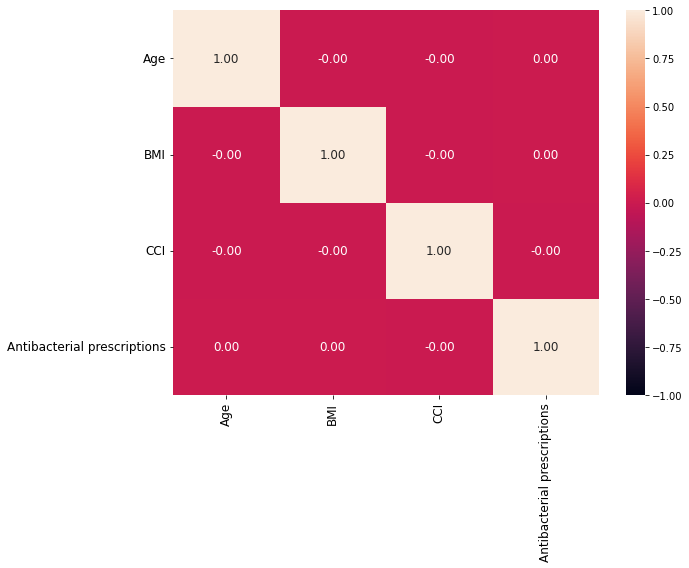

In [47]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data_urti[['age', 'bmi', 'CCI', 'antibacterial_brit']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions'], rotation=90, fontsize=12)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions',], rotation=0, fontsize=12)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/corr_urti.jpg')
plt.show()

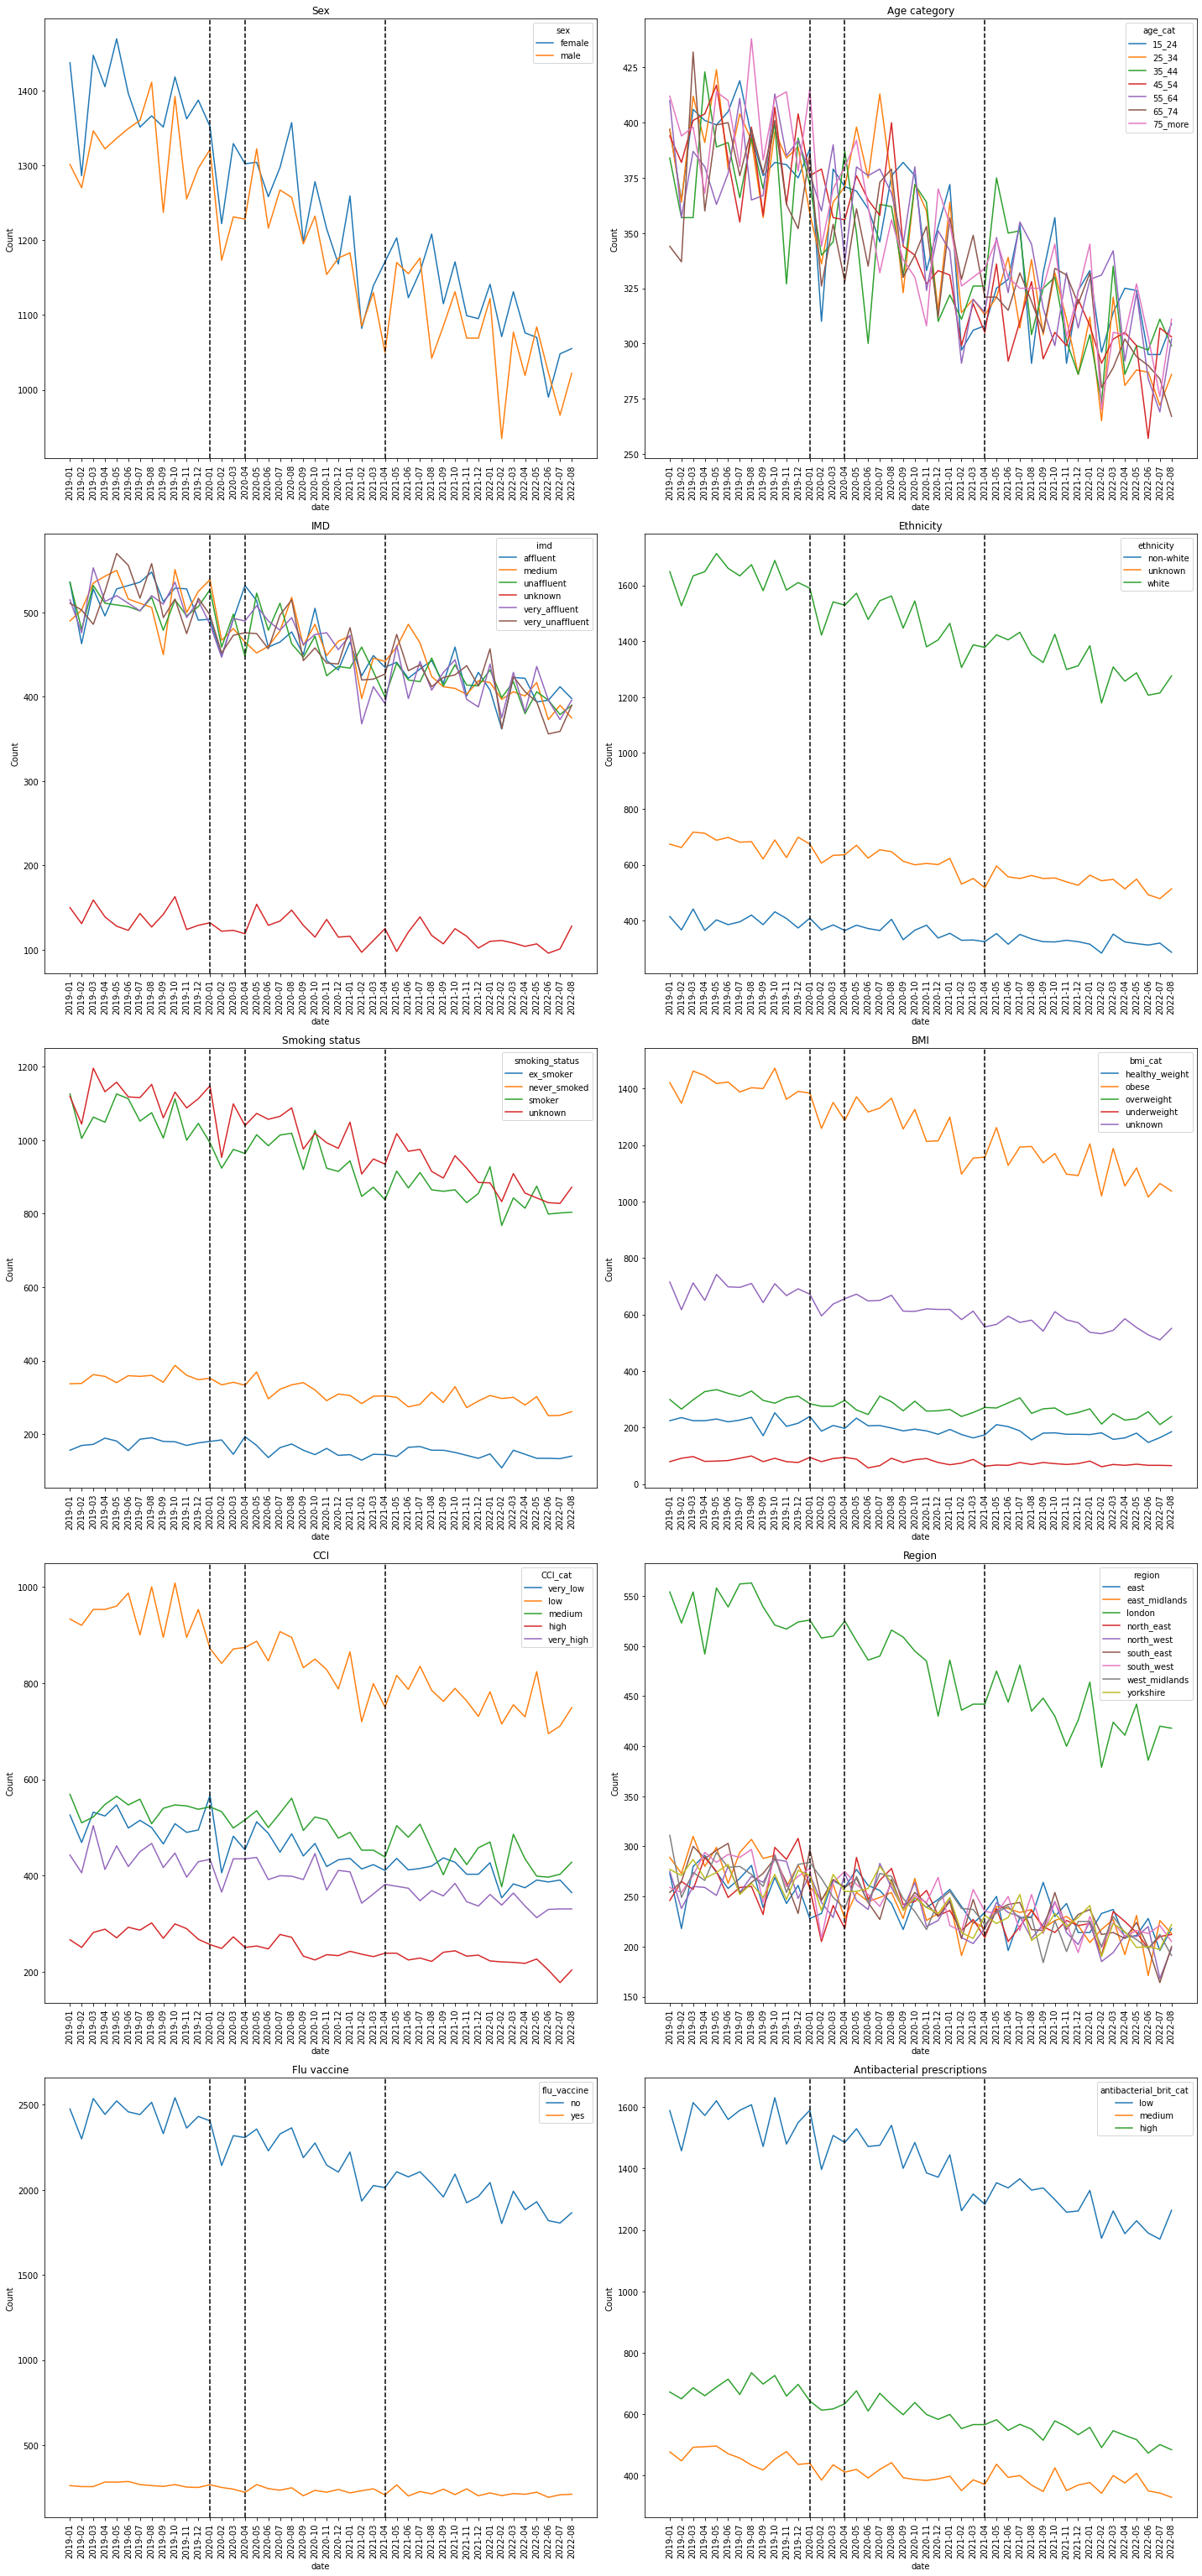

In [48]:
fig, axes = plt.subplots(5,2,
                        figsize=(20, 45)
                        )
create_lineplot(data_urti, 'sex', 'Sex', axes[0,0])
create_lineplot(data_urti, 'age_cat', 'Age category', axes[0,1])
create_lineplot(data_urti, 'imd', 'IMD', axes[1,0])
create_lineplot(data_urti, 'ethnicity', 'Ethnicity', axes[1,1])
create_lineplot(data_urti, 'smoking_status', 'Smoking status', axes[2,0])
create_lineplot(data_urti, 'bmi_cat', 'BMI', axes[2,1])
create_lineplot(data_urti, 'CCI_cat', 'CCI', axes[3,0])
create_lineplot(data_urti, 'region', 'Region', axes[3,1])
create_lineplot(data_urti, 'flu_vaccine', 'Flu vaccine', axes[4,0])
create_lineplot(data_urti, 'antibacterial_brit_cat', 'Antibacterial prescriptions', axes[4,1])
# fig.delaxes(ax=axes[5,1])

# fig.suptitle('Risk Factors of urti patients', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])
#plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/risk_factors_cat_urti.jpg')
plt.show()

## 4- separate data of incident/prevalent and with/without antibiotics
We separate data of urti to form four sub-datasets for 1) no antibiotics and incident admission, 2) with antibiotics and incident admission, 3) no antibiotics and prevalent admission, and 4) with antiobiotics and prevalent admission.

In [49]:
data_urti = data_urti[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 
                       'antibacterial_brit', 'urti_ab_date', 'ab_type_cat', 'incdt_urti_date', 'date',
                       'event_urti_admitted', 'duration_urti_admitted'
                        ]]

data_urti.shape

(106599, 17)

In [50]:
#incident and prevalent infection 
data_urti_incdt = data_urti[data_urti['incdt_urti_date'] == 0]
data_urti_prevl = data_urti[data_urti['incdt_urti_date'] == 1]
#switch variable urti_ab_date into a binary variable
data_urti_incdt[['urti_ab_date']] = data_urti_incdt[['urti_ab_date']].where(data_urti_incdt[['urti_ab_date']].isnull(), 1).fillna(0).astype(int)
data_urti_prevl[['urti_ab_date']] = data_urti_prevl[['urti_ab_date']].where(data_urti_prevl[['urti_ab_date']].isnull(), 1).fillna(0).astype(int)

#incident and prevalent infection stratified by sex categories
data_urti_incdt_males = data_urti_incdt[data_urti_incdt['sex'] == 'male']
data_urti_incdt_females = data_urti_incdt[data_urti_incdt['sex'] == 'female']
data_urti_prevl_males = data_urti_prevl[data_urti_prevl['sex'] == 'male']
data_urti_prevl_females = data_urti_prevl[data_urti_prevl['sex'] == 'female']

#incident and prevalent infection stratified by age categories
data_urti_incdt_15_24 = data_urti_incdt[data_urti_incdt['age_cat'] == '15_24']
data_urti_incdt_25_34 = data_urti_incdt[data_urti_incdt['age_cat'] == '25_34']
data_urti_incdt_35_44 = data_urti_incdt[data_urti_incdt['age_cat'] == '35_44']
data_urti_incdt_45_54 = data_urti_incdt[data_urti_incdt['age_cat'] == '45_54']
data_urti_incdt_55_64 = data_urti_incdt[data_urti_incdt['age_cat'] == '55_64']
data_urti_incdt_65_74 = data_urti_incdt[data_urti_incdt['age_cat'] == '65_74']
data_urti_incdt_75_more = data_urti_incdt[data_urti_incdt['age_cat'] == '75_more']
data_urti_prevl_15_24 = data_urti_prevl[data_urti_prevl['age_cat'] == '15_24']
data_urti_prevl_25_34 = data_urti_prevl[data_urti_prevl['age_cat'] == '25_34']
data_urti_prevl_35_44 = data_urti_prevl[data_urti_prevl['age_cat'] == '35_44']
data_urti_prevl_45_54 = data_urti_prevl[data_urti_prevl['age_cat'] == '45_54']
data_urti_prevl_55_64 = data_urti_prevl[data_urti_prevl['age_cat'] == '55_64']
data_urti_prevl_65_74 = data_urti_prevl[data_urti_prevl['age_cat'] == '65_74']
data_urti_prevl_75_more = data_urti_prevl[data_urti_prevl['age_cat'] == '75_more']

data_urti_incdt_prepandemic = data_urti_incdt[data_urti_incdt['date'] <= '2019-12']
data_urti_incdt_during_pandemic = data_urti_incdt[(data_urti_incdt['date'] >= '2020-03') & (data_urti_incdt['date']<= '2021-03')]
data_urti_incdt_post_2nd_lockdown = data_urti_incdt[data_urti_incdt['date'] <= '2021-04']
data_urti_prevl_prepandemic = data_urti_prevl[data_urti_prevl['date'] <= '2019-12']
data_urti_prevl_during_pandemic = data_urti_prevl[(data_urti_prevl['date'] >= '2020-03') & (data_urti_prevl['date']<= '2021-03')]
data_urti_prevl_post_2nd_lockdown = data_urti_prevl[data_urti_prevl['date'] <= '2021-04']

# #incident and prevalent infection stratified by ab categories
# data_urti_incdt_abtype_0 = data_urti_incdt[data_urti_incdt['ab_type_cat'] == data_urti['ab_type_cat'].unique()[0]]
# data_urti_incdt_abtype_1 = data_urti_incdt[data_urti_incdt['ab_type_cat'] == data_urti['ab_type_cat'].unique()[1]]
# data_urti_incdt_abtype_2 = data_urti_incdt[data_urti_incdt['ab_type_cat'] == data_urti['ab_type_cat'].unique()[2]]
# data_urti_incdt_abtype_3 = data_urti_incdt[data_urti_incdt['ab_type_cat'] == data_urti['ab_type_cat'].unique()[3]]
# data_urti_prevl_abtype_0 = data_urti_prevl[data_urti_prevl['ab_type_cat'] == data_urti['ab_type_cat'].unique()[0]]
# data_urti_prevl_abtype_1 = data_urti_prevl[data_urti_prevl['ab_type_cat'] == data_urti['ab_type_cat'].unique()[1]]
# data_urti_prevl_abtype_2 = data_urti_prevl[data_urti_prevl['ab_type_cat'] == data_urti['ab_type_cat'].unique()[2]]
# data_urti_prevl_abtype_3 = data_urti_prevl[data_urti_prevl['ab_type_cat'] == data_urti['ab_type_cat'].unique()[3]]

# #incident and prevalent infection with antibiotics type
# data_urti_incdt_abs = data_urti_incdt[data_urti_incdt['urti_ab_date'] == 1]
# data_urti_prevl_abs = data_urti_prevl[data_urti_prevl['urti_ab_date'] == 1]

# no antibiotics and incident hospital admission
data_urti_no_abs_incdt = data_urti[data_urti['urti_ab_date'].isnull()] #gp_cons_urti_ab
data_urti_no_abs_incdt = data_urti_no_abs_incdt[data_urti_no_abs_incdt['incdt_urti_date'] == 0]

# with antibiotics and incident hospital admission
data_urti_abs_incdt = data_urti[data_urti['urti_ab_date'].notnull()]
data_urti_abs_incdt = data_urti_abs_incdt[data_urti_abs_incdt['incdt_urti_date'] == 0]

# no antibiotics and prevalent hospital admission
data_urti_no_abs_prevl = data_urti[data_urti['urti_ab_date'].isnull()]
data_urti_no_abs_prevl = data_urti_no_abs_prevl[data_urti_no_abs_prevl['incdt_urti_date'] == 1]

# with antibiotics and prevalent hospital admission
data_urti_abs_prevl = data_urti[data_urti['urti_ab_date'].notnull()]
data_urti_abs_prevl = data_urti_abs_prevl[data_urti_abs_prevl['incdt_urti_date'] == 1]

print(f'shape of data_urti_incdt: {data_urti_incdt.shape}')
print(f'shape of data_urti_prevl: {data_urti_prevl.shape}')
print(f'shape of data_urti_no_abs_incdt: {data_urti_no_abs_incdt.shape}')
print(f'shape of data_urti_abs_incdt: {data_urti_abs_incdt.shape}')
print(f'shape of data_urti_no_abs_prevl: {data_urti_no_abs_prevl.shape}')
print(f'shape of data_urti_abs_prevl: {data_urti_abs_prevl.shape}')
print(f'\nvalue counts of data_urti_no_abs_incdt: \n{data_urti_no_abs_incdt.event_urti_admitted.value_counts()}')
print(f'value counts of data_urti_abs_incdt: \n{data_urti_abs_incdt.event_urti_admitted.value_counts()}')
print(f'value counts of data_urti_no_abs_prevl: \n{data_urti_no_abs_prevl.event_urti_admitted.value_counts()}')
print(f'value counts of data_urti_abs_prevl: \n{data_urti_abs_prevl.event_urti_admitted.value_counts()}')

shape of data_urti_incdt: (96074, 17)
shape of data_urti_prevl: (10525, 17)
shape of data_urti_no_abs_incdt: (86663, 17)
shape of data_urti_abs_incdt: (9411, 17)
shape of data_urti_no_abs_prevl: (9458, 17)
shape of data_urti_abs_prevl: (1067, 17)

value counts of data_urti_no_abs_incdt: 
0.0    85977
1.0      686
Name: event_urti_admitted, dtype: int64
value counts of data_urti_abs_incdt: 
0.0    9344
1.0      67
Name: event_urti_admitted, dtype: int64
value counts of data_urti_no_abs_prevl: 
0.0    9394
1.0      64
Name: event_urti_admitted, dtype: int64
value counts of data_urti_abs_prevl: 
0.0    1066
1.0       1
Name: event_urti_admitted, dtype: int64


In [51]:
#store data for plotting hosp admission counts and percentages
%store data_urti
# save data
data_urti.to_csv('../output/hospitalisation_prediction_urti/data_urti.csv')

Stored 'data_urti' (DataFrame)


## 5- cox modelling for hospital admissions
### 5-1- incident urti with no antibiotics

<lifelines.CoxPHFitter: fitted with 64997 total observations, 64476 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 64997
number of events observed = 521
   partial log-likelihood = -5755.23
         time fit was run = 2022-11-17 10:46:32 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.20       0.82       0.12            -0.43             0.04                 0.65                 1.04
CCI_cat[T.medium]               -0.16       0.85       0.13            -0.43             0.10                 0.65                 1.10
CCI_cat[T.high]                 -0.40       0.67       0.18            -0.75            -0.05                 0.47                 0.95
CCI_cat[T.very_high]            -0.26       0.77       0.15            -0.55             0.02                 0.58                 1.02
age_cat[T.25_34]                 0.26       1.29       0.17            -0.07             0.59                 0.93                 1.80
age_cat[T.35_44]                 0.23       1.26       0.17            -0.10             0.56                 0.90                 1.75
age_cat[T.45_54]                 0.13       1.14       0.17            -0.21             0.47                 0.81                 1.60
age_cat[T.55_64]                 0.13       1.14       0.17            -0.21             0.47                 0.81                 1.60
age_cat[T.65_74]                 0.20       1.23       0.17            -0.13             0.54                 0.88                 1.71
age_cat[T.75_more]               0.23       1.26       0.17            -0.10             0.56                 0.90                 1.75
antibacterial_brit              -0.01       0.99       0.03            -0.07             0.05                 0.93                 1.05
bmi_cat[T.obese]                 0.31       1.36       0.19            -0.06             0.67                 0.94                 1.96
bmi_cat[T.overweight]            0.36       1.43       0.22            -0.07             0.78                 0.93                 2.18
bmi_cat[T.underweight]           0.45       1.56       0.29            -0.11             1.00                 0.89                 2.73
bmi_cat[T.unknown]               0.23       1.26       0.20            -0.15             0.62                 0.86                 1.86
ethnicity[T.unknown]             0.23       1.26       0.15            -0.06             0.51                 0.94                 1.67
ethnicity[T.white]               0.06       1.06       0.13            -0.20             0.32                 0.82                 1.38
flu_vaccine[T.yes]              -0.03       0.97       0.15            -0.32             0.26                 0.72                 1.30
imd[T.medium]                   -0.03       0.97       0.13            -0.29             0.24                 0.75                 1.27
imd[T.unaffluent]               -0.22       0.80       0.14            -0.50             0.06                 0.60                 1.06
imd[T.unknown]                  -0.15       0.86       0.22            -0.57             0.28                 0.56                 1.32
imd[T.very_affluent]            -0.19       0.82       0.14            -0.47             0.08                 0.63                 1.09
imd[T.very_unaffluent]          -0.17       0.84       0.14            -0.45             0.10                 0.64                 1.11
region[T.east_midlands]         -0.00       1.00       0.20            -0.40             0.40                 0.67                 1.49
region[T.london]                 0.05       1.05       0.17         

12774


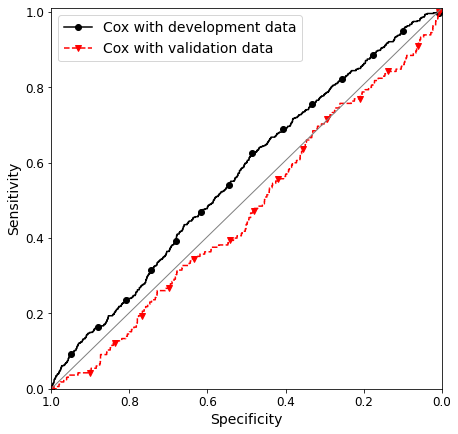

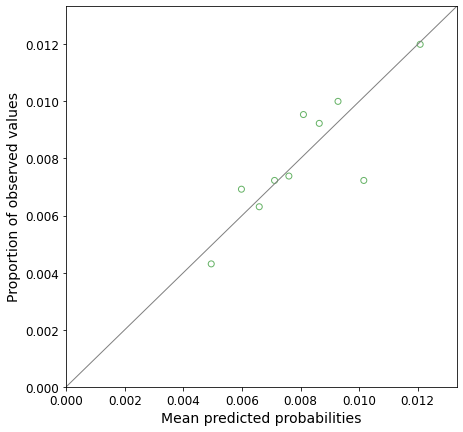

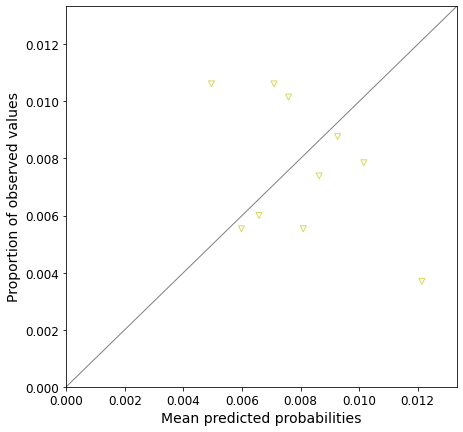

In [52]:
#data prep
data, data_urti_no_abs_incdt_enc = cox_data_prep(data_urti_no_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

#make summary table
make_summary_table('urti', 'no_abs_incdt', data_urti_no_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('urti', 'no_abs_incdt', data_urti_no_abs_incdt)

try:
    #build cox model 
    cph_urti_no_abs_incdt, data_urti_no_abs_incdt_train, data_urti_no_abs_incdt_test = cox_model_build('urti', 'no_abs_incdt', data_urti_no_abs_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    betas_sumbetas_calculate(cph_urti_no_abs_incdt, '../output/hospitalisation_prediction_urti/', 'betas_cph_urti_no_abs_incdt.csv', data_urti_no_abs_incdt_enc, data_urti_no_abs_incdt, 'sum_betas_cph_urti_no_abs_incdt.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cph_roc_curve(cph_urti_no_abs_incdt, 'event_urti_admitted', data_urti_no_abs_incdt_train, data_urti_no_abs_incdt_test, '../output/hospitalisation_prediction_urti', 'roc_cph_urti_no_abs_incdt.jpg')

    #plot calibration plots with development and validation data
    cph_calibration(cph_urti_no_abs_incdt, data_urti_no_abs_incdt_train, 'event_urti_admitted', data_urti_no_abs_incdt_test, '../output/hospitalisation_prediction_urti/', 'calibration_cph_urti_no_abs_incdt_train.jpg', 'calibration_cph_urti_no_abs_incdt_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cph_output(cph_urti_no_abs_incdt, 'urti', 'no_abs_incdt', data_urti_no_abs_incdt_train, data_urti_no_abs_incdt_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-2- incident urti with antibiotics

<lifelines.CoxPHFitter: fitted with 7058 total observations, 7002 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 7058
number of events observed = 56
   partial log-likelihood = -475.94
         time fit was run = 2022-11-17 10:46:44 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.82       2.28       0.42            -0.00             1.65                 1.00                 5.21
CCI_cat[T.medium]                0.52       1.68       0.47            -0.40             1.44                 0.67                 4.22
CCI_cat[T.high]                 -0.17       0.85       0.69            -1.52             1.19                 0.22                 3.27
CCI_cat[T.very_high]            -0.40       0.67       0.63            -1.63             0.83                 0.20                 2.30
age_cat[T.25_34]                -0.04       0.96       0.49            -1.00             0.91                 0.37                 2.49
age_cat[T.35_44]                -0.31       0.73       0.53            -1.35             0.73                 0.26                 2.07
age_cat[T.45_54]                -0.27       0.76       0.53            -1.31             0.77                 0.27                 2.16
age_cat[T.55_64]                 0.35       1.41       0.44            -0.52             1.21                 0.59                 3.37
age_cat[T.65_74]                 0.08       1.08       0.47            -0.85             1.00                 0.43                 2.73
age_cat[T.75_more]              -0.39       0.68       0.53            -1.43             0.64                 0.24                 1.90
antibacterial_brit               0.08       1.08       0.09            -0.11             0.26                 0.90                 1.29
bmi_cat[T.obese]                 0.00       1.00       0.48            -0.94             0.94                 0.39                 2.57
bmi_cat[T.overweight]            0.15       1.16       0.56            -0.95             1.25                 0.39                 3.47
bmi_cat[T.underweight]         -15.91       0.00    2029.31         -3993.28          3961.47                 0.00                  inf
bmi_cat[T.unknown]              -0.62       0.54       0.56            -1.71             0.48                 0.18                 1.61
ethnicity[T.unknown]             0.21       1.23       0.50            -0.77             1.19                 0.46                 3.30
ethnicity[T.white]               0.48       1.61       0.44            -0.39             1.34                 0.68                 3.82
flu_vaccine[T.yes]              -0.31       0.73       0.52            -1.33             0.71                 0.26                 2.04
imd[T.medium]                   -0.52       0.59       0.48            -1.46             0.41                 0.23                 1.51
imd[T.unaffluent]                0.15       1.16       0.40            -0.64             0.94                 0.53                 2.56
imd[T.unknown]                  -0.04       0.96       0.65            -1.31             1.23                 0.27                 3.43
imd[T.very_affluent]             0.24       1.27       0.40            -0.53             1.02                 0.59                 2.76
imd[T.very_unaffluent]          -0.51       0.60       0.48            -1.44             0.43                 0.24                 1.53
region[T.east_midlands]         -1.38       0.25       0.79            -2.93             0.17                 0.05                 1.19
region[T.london]                -0.78       0.46       0.50            -1

12786


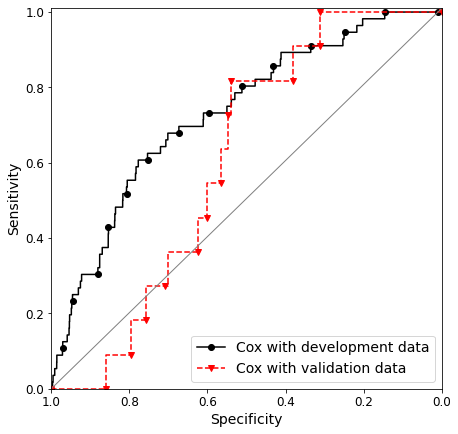

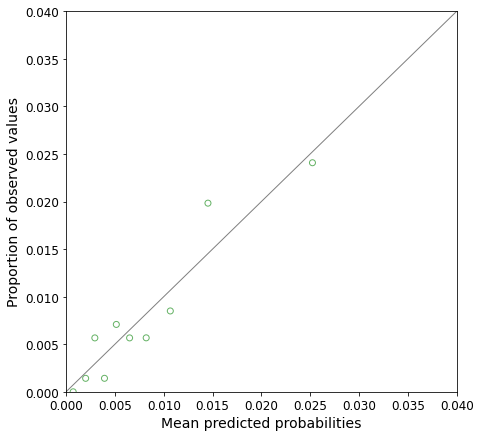

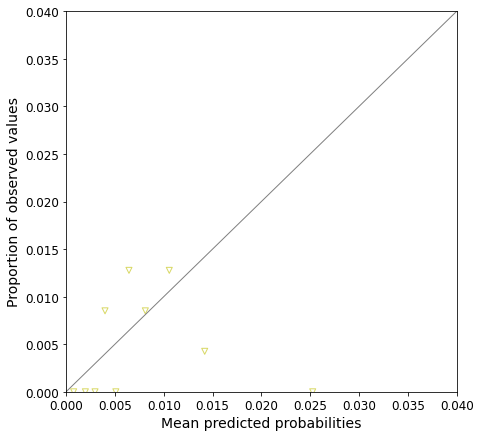

In [53]:
#data prep
data, data_urti_abs_incdt_enc = cox_data_prep(data_urti_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

#make summary table
make_summary_table('urti', 'abs_incdt', data_urti_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('urti', 'abs_incdt', data_urti_abs_incdt)

try:
    #build cox model 
    cph_urti_abs_incdt, data_urti_abs_incdt_train, data_urti_abs_incdt_test = cox_model_build('urti', 'abs_incdt', data_urti_abs_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    betas_sumbetas_calculate(cph_urti_abs_incdt, '../output/hospitalisation_prediction_urti/', 'betas_cph_urti_abs_incdt.csv', data_urti_abs_incdt_enc, data_urti_abs_incdt, 'sum_betas_cph_urti_abs_incdt.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cph_roc_curve(cph_urti_abs_incdt, 'event_urti_admitted', data_urti_abs_incdt_train, data_urti_abs_incdt_test, '../output/hospitalisation_prediction_urti', 'roc_cph_urti_abs_incdt.jpg')

    #plot calibration plots with development and validation data
    cph_calibration(cph_urti_abs_incdt, data_urti_abs_incdt_train, 'event_urti_admitted', data_urti_abs_incdt_test, '../output/hospitalisation_prediction_urti/', 'calibration_cph_urti_abs_incdt_train.jpg', 'calibration_cph_urti_abs_incdt_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cph_output(cph_urti_abs_incdt, 'urti', 'abs_incdt', data_urti_abs_incdt_train, data_urti_abs_incdt_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-3- prevalent urti with no antibiotics

<lifelines.CoxPHFitter: fitted with 7093 total observations, 7046 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 7093
number of events observed = 47
   partial log-likelihood = -396.12
         time fit was run = 2022-11-17 10:46:52 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.80       2.21       0.46            -0.11             1.70                 0.90                 5.46
CCI_cat[T.medium]                0.45       1.58       0.52            -0.56             1.47                 0.57                 4.35
CCI_cat[T.high]                  0.02       1.02       0.71            -1.37             1.40                 0.25                 4.08
CCI_cat[T.very_high]             0.03       1.03       0.61            -1.16             1.22                 0.31                 3.39
age_cat[T.25_34]                -0.26       0.77       0.53            -1.30             0.77                 0.27                 2.17
age_cat[T.35_44]                -0.33       0.72       0.53            -1.37             0.71                 0.26                 2.03
age_cat[T.45_54]                -0.14       0.87       0.51            -1.13             0.86                 0.32                 2.35
age_cat[T.55_64]                 0.20       1.22       0.46            -0.71             1.10                 0.49                 3.01
age_cat[T.65_74]                -0.43       0.65       0.56            -1.53             0.67                 0.22                 1.95
age_cat[T.75_more]              -0.73       0.48       0.60            -1.92             0.45                 0.15                 1.57
antibacterial_brit              -0.24       0.78       0.12            -0.48            -0.01                 0.62                 0.99
bmi_cat[T.obese]                -0.88       0.41       0.44            -1.75            -0.02                 0.17                 0.98
bmi_cat[T.overweight]           -1.62       0.20       0.80            -3.19            -0.04                 0.04                 0.96
bmi_cat[T.underweight]          -0.39       0.68       0.81            -1.97             1.19                 0.14                 3.30
bmi_cat[T.unknown]              -0.37       0.69       0.46            -1.27             0.52                 0.28                 1.68
ethnicity[T.unknown]             0.10       1.10       0.45            -0.77             0.97                 0.46                 2.64
ethnicity[T.white]              -0.28       0.75       0.41            -1.08             0.52                 0.34                 1.68
flu_vaccine[T.yes]               0.07       1.07       0.48            -0.86             1.00                 0.42                 2.72
imd[T.medium]                   -0.26       0.77       0.53            -1.30             0.78                 0.27                 2.17
imd[T.unaffluent]                0.59       1.80       0.42            -0.24             1.42                 0.78                 4.12
imd[T.unknown]                  -0.72       0.49       1.06            -2.79             1.35                 0.06                 3.85
imd[T.very_affluent]            -0.32       0.72       0.53            -1.36             0.71                 0.26                 2.04
imd[T.very_unaffluent]           0.14       1.15       0.46            -0.76             1.04                 0.47                 2.84
region[T.east_midlands]          0.02       1.02       0.58            -1.11             1.16                 0.33                 3.19
region[T.london]                -0.53       0.59       0.56            -1

12777


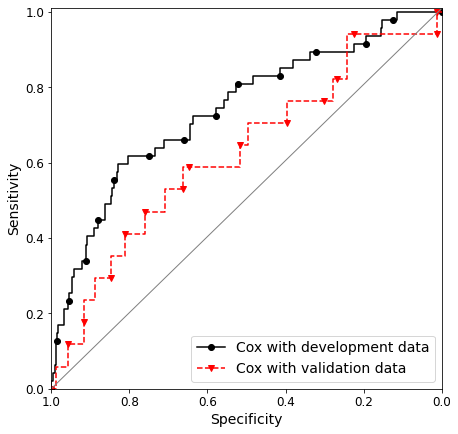

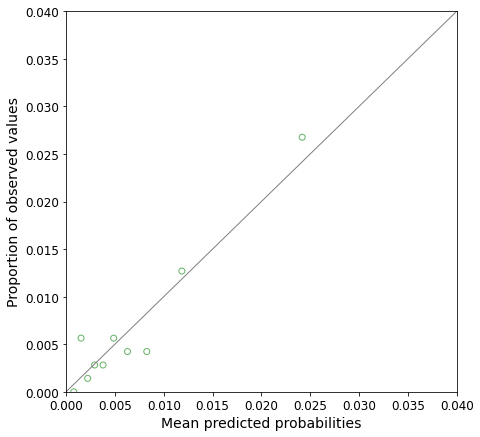

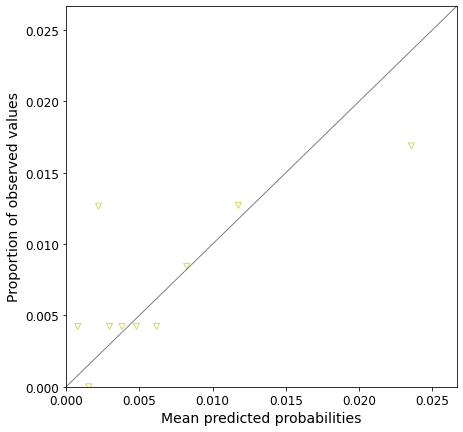

In [54]:
#data prep
data, data_urti_no_abs_prevl_enc = cox_data_prep(data_urti_no_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

#make summary table
make_summary_table('urti', 'no_abs_prevl', data_urti_no_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('urti', 'no_abs_prevl', data_urti_no_abs_prevl)

try:
    #build cox model 
    cph_urti_no_abs_prevl, data_urti_no_abs_prevl_train, data_urti_no_abs_prevl_test = cox_model_build('urti', 'no_abs_prevl', data_urti_no_abs_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:    
    #calculate and save betas and sum of betas 
    betas_sumbetas_calculate(cph_urti_no_abs_prevl, '../output/hospitalisation_prediction_urti/', 'betas_cph_urti_no_abs_prevl.csv', data_urti_no_abs_prevl_enc, data_urti_no_abs_prevl, 'sum_betas_cph_urti_no_abs_prevl.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cph_roc_curve(cph_urti_no_abs_prevl, 'event_urti_admitted', data_urti_no_abs_prevl_train, data_urti_no_abs_prevl_test, '../output/hospitalisation_prediction_urti', 'roc_cph_urti_no_abs_prevl.jpg')

    #plot calibration plots with development and validation data
    cph_calibration(cph_urti_no_abs_prevl, data_urti_no_abs_prevl_train, 'event_urti_admitted', data_urti_no_abs_prevl_test, '../output/hospitalisation_prediction_urti/', 'calibration_cph_urti_no_abs_prevl_train.jpg', 'calibration_cph_urti_no_abs_prevl_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cph_output(cph_urti_no_abs_prevl, 'urti', 'no_abs_prevl', data_urti_no_abs_prevl_train, data_urti_no_abs_prevl_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-4- prevalent urti with antibiotics

In [55]:
#data prep
data, data_urti_abs_prevl_enc = cox_data_prep(data_urti_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

#make summary table
make_summary_table('urti', 'abs_prevl', data_urti_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('urti', 'abs_prevl', data_urti_abs_prevl)

try:
    #build cox model 
    cph_urti_abs_prevl, data_urti_abs_prevl_train, data_urti_abs_prevl_test = cox_model_build('urti', 'abs_prevl', data_urti_abs_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    betas_sumbetas_calculate(cph_urti_abs_prevl, '../output/hospitalisation_prediction_urti/', 'betas_cph_urti_abs_prevl.csv', data_urti_abs_prevl_enc, data_urti_abs_prevl, 'sum_betas_cph_urti_abs_prevl.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cph_roc_curve(cph_urti_abs_prevl, 'event_urti_admitted', data_urti_abs_prevl_train, data_urti_abs_prevl_test, '../output/hospitalisation_prediction_urti', 'roc_cph_urti_abs_prevl.jpg')

    #plot calibration plots with development and validation data
    cph_calibration(cph_urti_abs_prevl, data_urti_abs_prevl_train, 'event_urti_admitted', data_urti_abs_prevl_test, '../output/hospitalisation_prediction_urti/', 'calibration_cph_urti_abs_prevl_train.jpg', 'calibration_cph_urti_abs_prevl_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cph_output(cph_urti_abs_prevl, 'urti', 'abs_prevl', data_urti_abs_prevl_train, data_urti_abs_prevl_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 800 total observations, 799 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 800
number of events observed = 1
   partial log-likelihood = -0.00
         time fit was run = 2022-11-17 10:47:00 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -4.50       0.01   11167.85        -21893.09         21884.09                 0.00                  inf
CCI_cat[T.medium]               -2.04       0.13   12905.81        -25296.97         25292.88                 0.00                  inf
CCI_cat[T.high]                 -5.72       0.00   16494.16        -32333.69         32322.25                 0.00                  inf
CCI_cat[T.very_high]            -4.49       0.01   17018.55        -33360.24         33351.26                 0.00                  inf
age_cat[T.25_34]                -3.48       0.03   16480.34        -32304.34         32297.39                 0.00                  inf
age_cat[T.35_44]                -5.25       0.01   14503.29        -28431.17         28420.66                 0.00                  inf
age_cat[T.45_54]                -2.20       0.11   14327.58        -28083.74         28079.34                 0.00                  inf
age_cat[T.55_64]                -5.60       0.00   16487.23        -32319.98         32308.77                 0.00                  inf
age_cat[T.65_74]                -3.97       0.02   19289.52        -37810.73         37802.78                 0.00                  inf
age_cat[T.75_more]              -4.03       0.02   16721.46        -32777.49         32769.44                 0.00                  inf
antibacterial_brit              -1.16       0.31    4146.73         -8128.60          8126.28                 0.00                  inf
bmi_cat[T.obese]                 4.92     136.68   22739.83        -44564.33         44574.16                 0.00                  inf
bmi_cat[T.overweight]            1.79       6.01   22444.47        -43988.55         43992.14                 0.00                  inf
bmi_cat[T.underweight]           8.37    4323.07   36998.94        -72508.21         72524.95                 0.00                  inf
bmi_cat[T.unknown]               1.42       4.13   24780.75        -48567.95         48570.79                 0.00                  inf
ethnicity[T.unknown]             5.52     248.97   18039.81        -35351.86         35362.90                 0.00                  inf
ethnicity[T.white]               3.79      44.46   17544.99        -34383.76         34391.35                 0.00                  inf
flu_vaccine[T.yes]              -4.48       0.01   22910.61        -44908.46         44899.49                 0.00                  inf
imd[T.medium]                    0.53       1.70   18099.11        -35473.07         35474.13                 0.00                  inf
imd[T.unaffluent]                2.29       9.90   21413.40        -41967.20         41971.78                 0.00                  inf
imd[T.unknown]                   0.91       2.48   26069.20        -51093.79         51095.60                 0.00                  inf
imd[T.very_affluent]            -1.74       0.18   17571.22        -34440.71         34437.23                 0.00                  inf
imd[T.very_unaffluent]           7.12    1234.07   14161.53        -27748.96         27763.20                 0.00                  inf
region[T.east_midlands]         -0.46       0.63   20708.91        -40589.17         40588.25                 0.00                  inf
region[T.london]                 0.28       1.33   24803.35        -48613.39   

13193

error_3: roc curves or calibration curves failed.

error_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.


ValueError: arange: cannot compute length

<Figure size 504x504 with 1 Axes>

### 5-5- incident urti

In [56]:
#data prep
data, data_urti_incdt_enc = cox_data_prep(data_urti_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

#make summary tables from preped data
make_summary_table('urti', 'incdt', data_urti_incdt_enc)
make_summary_table_hosped('urti', 'incdt', data_urti_incdt)

try:
    cph_urti_incdt, data_urti_incdt_train, data_urti_incdt_test = cox_model_abs_build('urti', 'incdt', data_urti_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_urti_incdt, 'urti', 'incdt', data_urti_incdt_train, data_urti_incdt_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 72055 total observations, 71502 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 72055
number of events observed = 553
   partial log-likelihood = -6170.03
         time fit was run = 2022-11-17 10:51:34 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.01       0.99       0.12            -0.25             0.22                 0.78                 1.25
CCI_cat[T.medium]               -0.04       0.96       0.14            -0.30             0.23                 0.74                 1.25
CCI_cat[T.high]                 -0.18       0.84       0.17            -0.52             0.16                 0.60                 1.17
CCI_cat[T.very_high]            -0.08       0.93       0.14            -0.36             0.21                 0.70                 1.23
age_cat[T.25_34]                 0.12       1.13       0.16            -0.19             0.43                 0.83                 1.54
age_cat[T.35_44]                 0.04       1.04       0.16            -0.27             0.36                 0.76                 1.43
age_cat[T.45_54]                 0.02       1.02       0.16            -0.30             0.34                 0.74                 1.40
age_cat[T.55_64]                 0.10       1.10       0.16            -0.21             0.41                 0.81                 1.50
age_cat[T.65_74]                -0.00       1.00       0.16            -0.32             0.32                 0.73                 1.38
age_cat[T.75_more]               0.03       1.03       0.16            -0.28             0.35                 0.75                 1.41
antibacterial_brit              -0.03       0.97       0.03            -0.09             0.03                 0.91                 1.03
bmi_cat[T.obese]                 0.29       1.33       0.18            -0.07             0.64                 0.94                 1.90
bmi_cat[T.overweight]            0.50       1.65       0.21             0.10             0.91                 1.10                 2.47
bmi_cat[T.underweight]           0.10       1.11       0.31            -0.51             0.71                 0.60                 2.03
bmi_cat[T.unknown]               0.24       1.27       0.19            -0.13             0.62                 0.87                 1.85
ethnicity[T.unknown]             0.12       1.13       0.15            -0.17             0.41                 0.85                 1.50
ethnicity[T.white]               0.17       1.19       0.13            -0.08             0.43                 0.92                 1.54
flu_vaccine[T.yes]              -0.12       0.89       0.15            -0.41             0.17                 0.66                 1.19
imd[T.medium]                   -0.03       0.97       0.13            -0.30             0.23                 0.74                 1.26
imd[T.unaffluent]               -0.08       0.92       0.14            -0.35             0.19                 0.71                 1.21
imd[T.unknown]                  -0.08       0.92       0.21            -0.50             0.33                 0.61                 1.40
imd[T.very_affluent]            -0.06       0.94       0.14            -0.33             0.20                 0.72                 1.23
imd[T.very_unaffluent]          -0.12       0.89       0.14            -0.39             0.16                 0.68                 1.17
region[T.east_midlands]         -0.18       0.84       0.20            -0.56             0.21                 0.57                 1.23
region[T.london]                -0.13       0.88       0.17         

13051


### 5-6- hospital admission related to prevalent urti

In [57]:
#data prep
data, data_urti_prevl_enc = cox_data_prep(data_urti_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

#make summary tables from preped data
make_summary_table('urti', 'prevl', data_urti_prevl_enc)
make_summary_table_hosped('urti', 'prevl', data_urti_prevl)

try:
    cph_urti_prevl, data_urti_prevl_train, data_urti_prevl_test = cox_model_abs_build('urti', 'prevl', data_urti_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_urti_prevl, 'urti', 'prevl', data_urti_prevl_train, data_urti_prevl_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 7893 total observations, 7842 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 7893
number of events observed = 51
   partial log-likelihood = -435.09
         time fit was run = 2022-11-17 10:51:38 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.45       1.56       0.42            -0.37             1.26                 0.69                 3.53
CCI_cat[T.medium]                0.32       1.37       0.46            -0.58             1.22                 0.56                 3.37
CCI_cat[T.high]                  0.18       1.20       0.57            -0.94             1.30                 0.39                 3.67
CCI_cat[T.very_high]            -0.47       0.63       0.61            -1.67             0.74                 0.19                 2.09
age_cat[T.25_34]                -0.27       0.76       0.49            -1.22             0.68                 0.29                 1.98
age_cat[T.35_44]                -0.69       0.50       0.54            -1.75             0.37                 0.17                 1.45
age_cat[T.45_54]                -0.32       0.73       0.49            -1.27             0.63                 0.28                 1.88
age_cat[T.55_64]                -0.09       0.92       0.45            -0.97             0.80                 0.38                 2.22
age_cat[T.65_74]                -0.44       0.64       0.51            -1.44             0.55                 0.24                 1.74
age_cat[T.75_more]              -0.53       0.59       0.51            -1.53             0.47                 0.22                 1.60
antibacterial_brit              -0.17       0.84       0.11            -0.39             0.04                 0.68                 1.04
bmi_cat[T.obese]                -0.99       0.37       0.40            -1.77            -0.21                 0.17                 0.81
bmi_cat[T.overweight]           -1.41       0.24       0.67            -2.73            -0.10                 0.07                 0.90
bmi_cat[T.underweight]          -0.59       0.55       0.79            -2.14             0.96                 0.12                 2.60
bmi_cat[T.unknown]              -0.64       0.53       0.42            -1.47             0.19                 0.23                 1.22
ethnicity[T.unknown]             0.04       1.04       0.40            -0.75             0.82                 0.47                 2.27
ethnicity[T.white]              -0.56       0.57       0.38            -1.30             0.18                 0.27                 1.20
flu_vaccine[T.yes]              -0.04       0.96       0.47            -0.97             0.89                 0.38                 2.42
imd[T.medium]                   -0.44       0.65       0.52            -1.45             0.58                 0.23                 1.78
imd[T.unaffluent]                0.52       1.68       0.40            -0.27             1.31                 0.76                 3.71
imd[T.unknown]                  -0.90       0.41       1.05            -2.96             1.16                 0.05                 3.18
imd[T.very_affluent]            -0.31       0.73       0.49            -1.28             0.66                 0.28                 1.93
imd[T.very_unaffluent]           0.07       1.08       0.44            -0.78             0.93                 0.46                 2.54
region[T.east_midlands]          0.35       1.42       0.59            -0.80             1.50                 0.45                 4.49
region[T.london]                -0.47       0.63       0.61            -1

13046


### 5-7- hospital admission related to incident urti with prescribed antibiotics categories

In [58]:
#data prep
data, data_urti_incdt_abs_enc = cox_data_prep(data_urti_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_incdt_abs, data_urti_incdt_abs_train, data_urti_incdt_abs_test = cox_model_ab_type_build('urti', 'incdt_ab_type', data_urti_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_urti_incdt_abs, 'urti', 'incdt_abs', data_urti_incdt_abs_train, data_urti_incdt_abs_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 72055 total observations, 71502 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 72055
number of events observed = 553
   partial log-likelihood = -6169.81
         time fit was run = 2022-11-17 10:51:40 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.01       0.99       0.12            -0.25             0.22                 0.78                 1.25
CCI_cat[T.medium]               -0.04       0.96       0.14            -0.31             0.23                 0.74                 1.25
CCI_cat[T.high]                 -0.18       0.84       0.17            -0.52             0.16                 0.60                 1.17
CCI_cat[T.very_high]            -0.08       0.93       0.14            -0.36             0.21                 0.70                 1.23
ab_type_cat[T.Doxycycline]      -0.21       0.81       1.12            -2.41             1.98                 0.09                 7.23
ab_type_cat[T.no]               -0.20       0.82       0.50            -1.18             0.78                 0.31                 2.19
ab_type_cat[T.other]            -0.36       0.70       0.52            -1.38             0.67                 0.25                 1.95
age_cat[T.25_34]                 0.12       1.13       0.16            -0.19             0.43                 0.83                 1.54
age_cat[T.35_44]                 0.04       1.04       0.16            -0.27             0.36                 0.76                 1.43
age_cat[T.45_54]                 0.02       1.02       0.16            -0.30             0.34                 0.74                 1.40
age_cat[T.55_64]                 0.10       1.10       0.16            -0.21             0.41                 0.81                 1.50
age_cat[T.65_74]                -0.00       1.00       0.16            -0.32             0.32                 0.73                 1.38
age_cat[T.75_more]               0.03       1.03       0.16            -0.28             0.35                 0.75                 1.41
antibacterial_brit              -0.03       0.97       0.03            -0.09             0.03                 0.91                 1.03
bmi_cat[T.obese]                 0.29       1.33       0.18            -0.07             0.64                 0.93                 1.90
bmi_cat[T.overweight]            0.50       1.65       0.21             0.10             0.91                 1.10                 2.47
bmi_cat[T.underweight]           0.10       1.11       0.31            -0.51             0.71                 0.60                 2.03
bmi_cat[T.unknown]               0.24       1.27       0.19            -0.14             0.62                 0.87                 1.85
ethnicity[T.unknown]             0.12       1.13       0.15            -0.17             0.41                 0.85                 1.50
ethnicity[T.white]               0.17       1.19       0.13            -0.08             0.43                 0.92                 1.54
flu_vaccine[T.yes]              -0.12       0.89       0.15            -0.41             0.18                 0.66                 1.19
imd[T.medium]                   -0.03       0.97       0.13            -0.30             0.23                 0.74                 1.26
imd[T.unaffluent]               -0.08       0.93       0.14            -0.35             0.19                 0.71                 1.21
imd[T.unknown]                  -0.08       0.92       0.21            -0.49             0.33                 0.61                 1.40
imd[T.very_affluent]            -0.06       0.94       0.14         

13618


### 5-8- hospital admission related to prevalent urti with prescribed antibiotics categories

In [59]:
#data prep
data, data_urti_prevl_abs_enc = cox_data_prep(data_urti_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_prevl_abs, data_urti_prevl_abs_train, data_urti_prevl_abs_test = cox_model_ab_type_build('urti', 'prevl_ab_type', data_urti_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_urti_prevl_abs, 'urti', 'prevl_abs', data_urti_prevl_abs_train, data_urti_prevl_abs_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 7893 total observations, 7842 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 7893
number of events observed = 51
   partial log-likelihood = -434.99
         time fit was run = 2022-11-17 10:51:45 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.45       1.56       0.42            -0.37             1.26                 0.69                 3.53
CCI_cat[T.medium]                0.32       1.37       0.46            -0.58             1.22                 0.56                 3.37
CCI_cat[T.high]                  0.18       1.19       0.57            -0.94             1.30                 0.39                 3.66
CCI_cat[T.very_high]            -0.47       0.62       0.61            -1.67             0.73                 0.19                 2.08
ab_type_cat[T.Doxycycline]      -0.13       0.88    4839.47         -9485.31          9485.06                 0.00                  inf
ab_type_cat[T.no]               14.70   2.41e+06    2584.11         -5050.08          5079.47                 0.00                  inf
ab_type_cat[T.other]            13.08   4.81e+05    2584.11         -5051.69          5077.86                 0.00                  inf
age_cat[T.25_34]                -0.27       0.77       0.49            -1.22             0.68                 0.30                 1.98
age_cat[T.35_44]                -0.69       0.50       0.54            -1.75             0.37                 0.17                 1.45
age_cat[T.45_54]                -0.32       0.73       0.49            -1.27             0.63                 0.28                 1.88
age_cat[T.55_64]                -0.09       0.92       0.45            -0.97             0.80                 0.38                 2.22
age_cat[T.65_74]                -0.44       0.64       0.51            -1.44             0.56                 0.24                 1.75
age_cat[T.75_more]              -0.53       0.59       0.51            -1.53             0.47                 0.22                 1.60
antibacterial_brit              -0.17       0.84       0.11            -0.39             0.04                 0.68                 1.04
bmi_cat[T.obese]                -0.99       0.37       0.40            -1.77            -0.20                 0.17                 0.81
bmi_cat[T.overweight]           -1.41       0.24       0.67            -2.73            -0.10                 0.07                 0.90
bmi_cat[T.underweight]          -0.59       0.55       0.79            -2.14             0.96                 0.12                 2.60
bmi_cat[T.unknown]              -0.64       0.53       0.42            -1.47             0.20                 0.23                 1.22
ethnicity[T.unknown]             0.04       1.04       0.40            -0.75             0.82                 0.47                 2.28
ethnicity[T.white]              -0.56       0.57       0.38            -1.30             0.18                 0.27                 1.20
flu_vaccine[T.yes]              -0.04       0.96       0.47            -0.97             0.88                 0.38                 2.42
imd[T.medium]                   -0.44       0.64       0.52            -1.45             0.58                 0.23                 1.78
imd[T.unaffluent]                0.52       1.68       0.40            -0.28             1.31                 0.76                 3.71
imd[T.unknown]                  -0.90       0.41       1.05            -2.96             1.16                 0.05                 3.18
imd[T.very_affluent]            -0.31       0.73       0.49            -1

13643


### 5-9- stratified by sex
#### 5-9-1- incident males

In [60]:
#data prep
data, data_urti_incdt_males_enc = cox_data_prep(data_urti_incdt_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_incdt_males, data_urti_incdt_males_train, data_urti_incdt_males_test = cox_model_strat_sex_build('urti', 'incdt_males', data_urti_incdt_males)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_urti_incdt_males, 'urti', 'incdt_males', data_urti_incdt_males_train, data_urti_incdt_males_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 35361 total observations, 35075 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 35361
number of events observed = 286
   partial log-likelihood = -2978.01
         time fit was run = 2022-11-17 10:51:49 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.05       0.96       0.16            -0.37             0.28                 0.69                 1.32
CCI_cat[T.medium]               -0.01       0.99       0.18            -0.37             0.35                 0.69                 1.41
CCI_cat[T.high]                 -0.11       0.90       0.23            -0.56             0.34                 0.57                 1.41
CCI_cat[T.very_high]            -0.27       0.76       0.21            -0.68             0.14                 0.50                 1.15
age_cat[T.25_34]                 0.27       1.31       0.23            -0.18             0.72                 0.84                 2.05
age_cat[T.35_44]                 0.34       1.41       0.23            -0.10             0.78                 0.90                 2.19
age_cat[T.45_54]                 0.16       1.17       0.23            -0.30             0.62                 0.74                 1.85
age_cat[T.55_64]                 0.08       1.08       0.24            -0.39             0.54                 0.68                 1.72
age_cat[T.65_74]                 0.22       1.25       0.23            -0.23             0.67                 0.79                 1.96
age_cat[T.75_more]               0.18       1.19       0.23            -0.28             0.63                 0.76                 1.88
antibacterial_brit              -0.01       0.99       0.04            -0.09             0.07                 0.91                 1.08
bmi_cat[T.obese]                 0.36       1.43       0.26            -0.14             0.86                 0.87                 2.36
bmi_cat[T.overweight]            0.47       1.59       0.29            -0.10             1.04                 0.90                 2.82
bmi_cat[T.underweight]           0.26       1.30       0.41            -0.55             1.07                 0.58                 2.91
bmi_cat[T.unknown]               0.19       1.21       0.27            -0.34             0.73                 0.71                 2.07
ethnicity[T.unknown]             0.33       1.40       0.21            -0.08             0.75                 0.92                 2.11
ethnicity[T.white]               0.31       1.36       0.19            -0.07             0.68                 0.93                 1.98
flu_vaccine[T.yes]               0.08       1.09       0.19            -0.29             0.46                 0.75                 1.58
imd[T.medium]                    0.19       1.21       0.19            -0.17             0.56                 0.84                 1.75
imd[T.unaffluent]                0.08       1.08       0.19            -0.30             0.46                 0.74                 1.58
imd[T.unknown]                   0.13       1.13       0.29            -0.43             0.69                 0.65                 1.99
imd[T.very_affluent]             0.02       1.02       0.20            -0.36             0.41                 0.70                 1.50
imd[T.very_unaffluent]          -0.16       0.85       0.20            -0.56             0.23                 0.57                 1.26
region[T.east_midlands]          0.30       1.35       0.28            -0.24             0.84                 0.78                 2.32
region[T.london]                 0.38       1.47       0.24         

12760


#### 5-9-2- incident females

In [61]:
#data prep
data, data_urti_incdt_females_enc = cox_data_prep(data_urti_incdt_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_incdt_females, data_urti_incdt_females_train, data_urti_incdt_females_test = cox_model_strat_sex_build('urti', 'incdt_females', data_urti_incdt_females)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_urti_incdt_females, 'urti', 'incdt_females', data_urti_incdt_females_train, data_urti_incdt_females_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 36693 total observations, 36426 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 36693
number of events observed = 267
   partial log-likelihood = -2793.93
         time fit was run = 2022-11-17 10:51:51 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.02       0.98       0.18            -0.36             0.33                 0.70                 1.39
CCI_cat[T.medium]                0.01       1.01       0.20            -0.37             0.40                 0.69                 1.49
CCI_cat[T.high]                 -0.34       0.71       0.27            -0.86             0.18                 0.42                 1.20
CCI_cat[T.very_high]             0.16       1.18       0.20            -0.23             0.56                 0.80                 1.74
age_cat[T.25_34]                 0.23       1.25       0.22            -0.20             0.65                 0.82                 1.92
age_cat[T.35_44]                -0.19       0.82       0.24            -0.67             0.28                 0.51                 1.32
age_cat[T.45_54]                 0.16       1.17       0.22            -0.28             0.60                 0.76                 1.82
age_cat[T.55_64]                -0.03       0.97       0.23            -0.48             0.43                 0.62                 1.53
age_cat[T.65_74]                -0.05       0.95       0.23            -0.51             0.41                 0.60                 1.51
age_cat[T.75_more]              -0.11       0.90       0.23            -0.57             0.35                 0.57                 1.42
antibacterial_brit              -0.01       0.99       0.04            -0.09             0.08                 0.91                 1.08
bmi_cat[T.obese]                 0.48       1.61       0.28            -0.07             1.03                 0.93                 2.79
bmi_cat[T.overweight]            0.41       1.51       0.32            -0.23             1.04                 0.80                 2.84
bmi_cat[T.underweight]          -0.12       0.89       0.52            -1.14             0.91                 0.32                 2.47
bmi_cat[T.unknown]               0.42       1.52       0.29            -0.16             0.99                 0.86                 2.70
ethnicity[T.unknown]             0.01       1.01       0.20            -0.38             0.41                 0.68                 1.50
ethnicity[T.white]               0.00       1.00       0.18            -0.35             0.35                 0.70                 1.42
flu_vaccine[T.yes]              -0.09       0.92       0.21            -0.51             0.33                 0.60                 1.39
imd[T.medium]                   -0.13       0.87       0.19            -0.51             0.24                 0.60                 1.27
imd[T.unaffluent]               -0.22       0.80       0.20            -0.60             0.17                 0.55                 1.18
imd[T.unknown]                  -0.07       0.93       0.30            -0.66             0.51                 0.52                 1.67
imd[T.very_affluent]            -0.14       0.87       0.19            -0.52             0.24                 0.60                 1.27
imd[T.very_unaffluent]          -0.21       0.81       0.20            -0.60             0.17                 0.55                 1.19
region[T.east_midlands]         -0.29       0.74       0.27            -0.82             0.23                 0.44                 1.26
region[T.london]                -0.35       0.71       0.23         

12785


#### 5-9-3- prevalent males

In [62]:
#data prep
data, data_urti_prevl_males_enc = cox_data_prep(data_urti_prevl_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_prevl_males, data_urti_prevl_males_train, data_urti_prevl_males_test = cox_model_strat_sex_build('urti', 'prevl_males', data_urti_prevl_males)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:  
    # calculate c-statistics
    cph_output(cph_urti_prevl_males, 'urti', 'prevl_males', data_urti_prevl_males_train, data_urti_prevl_males_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 3818 total observations, 3793 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 3818
number of events observed = 25
   partial log-likelihood = -186.66
         time fit was run = 2022-11-17 10:51:53 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.12       1.12       0.56            -0.97             1.21                 0.38                 3.35
CCI_cat[T.medium]               -0.04       0.96       0.68            -1.38             1.30                 0.25                 3.66
CCI_cat[T.high]                 -0.03       0.97       0.85            -1.70             1.63                 0.18                 5.12
CCI_cat[T.very_high]            -0.02       0.98       0.68            -1.35             1.32                 0.26                 3.73
age_cat[T.25_34]                 0.02       1.02       0.77            -1.50             1.53                 0.22                 4.63
age_cat[T.35_44]                 0.58       1.79       0.66            -0.70             1.87                 0.49                 6.50
age_cat[T.45_54]                -0.44       0.64       0.87            -2.16             1.27                 0.12                 3.58
age_cat[T.55_64]                 0.19       1.21       0.72            -1.21             1.59                 0.30                 4.91
age_cat[T.65_74]                -0.42       0.66       0.88            -2.14             1.30                 0.12                 3.68
age_cat[T.75_more]               0.11       1.12       0.72            -1.29             1.51                 0.28                 4.55
antibacterial_brit              -0.26       0.77       0.17            -0.60             0.07                 0.55                 1.08
bmi_cat[T.obese]                -0.68       0.51       0.59            -1.84             0.48                 0.16                 1.62
bmi_cat[T.overweight]          -17.37       0.00    2845.13         -5593.72          5558.98                 0.00                  inf
bmi_cat[T.underweight]          -0.28       0.75       1.14            -2.52             1.95                 0.08                 7.02
bmi_cat[T.unknown]              -0.23       0.79       0.63            -1.47             1.00                 0.23                 2.72
ethnicity[T.unknown]             0.54       1.71       0.68            -0.79             1.86                 0.45                 6.41
ethnicity[T.white]              -0.06       0.94       0.65            -1.33             1.21                 0.26                 3.37
flu_vaccine[T.yes]              -0.23       0.79       0.74            -1.69             1.23                 0.18                 3.40
imd[T.medium]                   -0.75       0.47       0.84            -2.40             0.90                 0.09                 2.46
imd[T.unaffluent]                0.64       1.90       0.56            -0.46             1.75                 0.63                 5.75
imd[T.unknown]                 -16.87       0.00    4139.18         -8129.51          8095.78                 0.00                  inf
imd[T.very_affluent]            -0.03       0.97       0.68            -1.36             1.30                 0.26                 3.66
imd[T.very_unaffluent]           0.10       1.10       0.64            -1.15             1.35                 0.32                 3.86
region[T.east_midlands]          0.38       1.46       0.92            -1.43             2.18                 0.24                 8.85
region[T.london]                 0.16       1.18       0.84            -1

12797


#### 5-9-4- prevalent females

In [63]:
try:
    #data prep
    data, data_urti_prevl_females_enc = cox_data_prep(data_urti_prevl_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

    #cox model
    cph_urti_prevl_females, data_urti_prevl_females_train, data_urti_prevl_females_test = cox_model_strat_sex_build('urti', 'prevl_females', data_urti_prevl_females)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_urti_prevl_females, 'urti', 'prevl_females', data_urti_prevl_females_train, data_urti_prevl_females_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 4075 total observations, 4054 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 4075
number of events observed = 21
   partial log-likelihood = -156.28
         time fit was run = 2022-11-17 10:51:53 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.16       1.18       0.61            -1.03             1.35                 0.36                 3.87
CCI_cat[T.medium]               -0.00       1.00       0.68            -1.33             1.33                 0.26                 3.78
CCI_cat[T.high]                 -0.25       0.78       0.88            -1.98             1.48                 0.14                 4.37
CCI_cat[T.very_high]            -1.24       0.29       1.13            -3.45             0.96                 0.03                 2.62
age_cat[T.25_34]                -0.66       0.52       0.87            -2.37             1.06                 0.09                 2.88
age_cat[T.35_44]                -1.45       0.23       1.12            -3.65             0.75                 0.03                 2.11
age_cat[T.45_54]                 0.47       1.60       0.66            -0.82             1.75                 0.44                 5.77
age_cat[T.55_64]                 0.35       1.43       0.68            -0.97             1.68                 0.38                 5.37
age_cat[T.65_74]                -0.63       0.53       0.87            -2.34             1.08                 0.10                 2.95
age_cat[T.75_more]              -1.37       0.25       1.13            -3.57             0.84                 0.03                 2.31
antibacterial_brit              -0.09       0.91       0.17            -0.42             0.23                 0.66                 1.26
bmi_cat[T.obese]                -1.12       0.32       0.70            -2.50             0.25                 0.08                 1.28
bmi_cat[T.overweight]           -0.86       0.43       0.93            -2.68             0.97                 0.07                 2.63
bmi_cat[T.underweight]          -0.23       0.80       1.18            -2.54             2.09                 0.08                 8.10
bmi_cat[T.unknown]              -0.29       0.75       0.69            -1.64             1.06                 0.19                 2.87
ethnicity[T.unknown]             0.10       1.10       0.62            -1.12             1.32                 0.33                 3.73
ethnicity[T.white]              -0.78       0.46       0.61            -1.97             0.42                 0.14                 1.52
flu_vaccine[T.yes]              -0.12       0.89       0.76            -1.60             1.37                 0.20                 3.93
imd[T.medium]                   -0.27       0.76       0.92            -2.07             1.53                 0.13                 4.63
imd[T.unaffluent]                0.78       2.19       0.71            -0.62             2.18                 0.54                 8.87
imd[T.unknown]                   0.19       1.21       1.17            -2.10             2.47                 0.12                11.84
imd[T.very_affluent]             0.09       1.09       0.82            -1.53             1.70                 0.22                 5.49
imd[T.very_unaffluent]           0.62       1.86       0.72            -0.78             2.03                 0.46                 7.58
region[T.east_midlands]          0.19       1.21       0.83            -1.44             1.82                 0.24                 6.16
region[T.london]                -0.83       0.44       0.92            -2

12796


### 5-10- stratified by age category
#### 5-10-1- incident

In [64]:
#data prep
data, data_urti_incdt_15_24_enc = cox_data_prep(data_urti_incdt_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_incdt_15_24, data_urti_incdt_15_24_train, data_urti_incdt_15_24_test = cox_model_strat_age_build('urti', 'incdt_15_24', data_urti_incdt_15_24)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_urti_incdt_15_24, 'urti', 'incdt_15_24', data_urti_incdt_15_24_train, data_urti_incdt_15_24_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 10393 total observations, 10317 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 10393
number of events observed = 76
   partial log-likelihood = -692.36
         time fit was run = 2022-11-17 10:51:54 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.00       1.00       0.31            -0.61             0.62                 0.54                 1.85
CCI_cat[T.medium]               -0.36       0.70       0.38            -1.11             0.39                 0.33                 1.48
CCI_cat[T.high]                 -0.54       0.58       0.51            -1.55             0.47                 0.21                 1.59
CCI_cat[T.very_high]             0.06       1.06       0.37            -0.66             0.78                 0.52                 2.18
antibacterial_brit              -0.05       0.95       0.08            -0.21             0.11                 0.81                 1.12
bmi_cat[T.obese]                 0.27       1.30       0.47            -0.66             1.19                 0.52                 3.30
bmi_cat[T.overweight]            0.16       1.17       0.57            -0.96             1.27                 0.38                 3.58
bmi_cat[T.underweight]           0.02       1.02       0.84            -1.63             1.66                 0.20                 5.25
bmi_cat[T.unknown]               0.10       1.11       0.51            -0.89             1.10                 0.41                 2.99
ethnicity[T.unknown]             0.19       1.21       0.39            -0.57             0.96                 0.56                 2.62
ethnicity[T.white]               0.16       1.17       0.35            -0.53             0.84                 0.59                 2.32
flu_vaccine[T.yes]               0.26       1.29       0.36            -0.44             0.95                 0.64                 2.60
imd[T.medium]                   -0.44       0.65       0.40            -1.23             0.36                 0.29                 1.43
imd[T.unaffluent]                0.11       1.12       0.35            -0.57             0.80                 0.56                 2.22
imd[T.unknown]                   0.24       1.27       0.51            -0.77             1.24                 0.46                 3.46
imd[T.very_affluent]            -0.14       0.87       0.37            -0.85             0.58                 0.43                 1.79
imd[T.very_unaffluent]          -0.14       0.87       0.37            -0.86             0.58                 0.42                 1.78
region[T.east_midlands]         -0.10       0.90       0.45            -0.98             0.78                 0.38                 2.18
region[T.london]                -0.70       0.50       0.45            -1.58             0.18                 0.21                 1.20
region[T.north_east]            -0.43       0.65       0.52            -1.45             0.58                 0.24                 1.79
region[T.north_west]             0.12       1.13       0.44            -0.74             0.98                 0.48                 2.67
region[T.south_east]            -0.15       0.86       0.46            -1.05             0.75                 0.35                 2.12
region[T.south_west]            -0.27       0.76       0.48            -1.20             0.66                 0.30                 1.94
region[T.west_midlands]         -0.22       0.81       0.48            -1.15             0.72                 0.32                 2.05
region[T.yorkshire]             -0.97       0.38       0.59           

11396


In [65]:
#data prep
data, data_urti_incdt_25_34_enc = cox_data_prep(data_urti_incdt_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_incdt_25_34, data_urti_incdt_25_34_train, data_urti_incdt_25_34_test = cox_model_strat_age_build('urti', 'incdt_25_34', data_urti_incdt_25_34)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_urti_incdt_25_34, 'urti', 'incdt_25_34', data_urti_incdt_25_34_train, data_urti_incdt_25_34_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 10334 total observations, 10246 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 10334
number of events observed = 88
   partial log-likelihood = -798.29
         time fit was run = 2022-11-17 10:51:55 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.23       0.79       0.29            -0.81             0.34                 0.44                 1.41
CCI_cat[T.medium]               -0.23       0.79       0.33            -0.88             0.42                 0.41                 1.52
CCI_cat[T.high]                 -0.14       0.87       0.40            -0.93             0.65                 0.39                 1.91
CCI_cat[T.very_high]            -0.16       0.85       0.35            -0.85             0.52                 0.43                 1.69
antibacterial_brit              -0.02       0.98       0.08            -0.16             0.13                 0.85                 1.14
bmi_cat[T.obese]                 0.25       1.29       0.47            -0.67             1.18                 0.51                 3.25
bmi_cat[T.overweight]            0.62       1.85       0.52            -0.41             1.64                 0.67                 5.16
bmi_cat[T.underweight]           0.48       1.61       0.73            -0.96             1.91                 0.38                 6.77
bmi_cat[T.unknown]               0.21       1.23       0.50            -0.77             1.18                 0.46                 3.26
ethnicity[T.unknown]             0.33       1.39       0.37            -0.40             1.06                 0.67                 2.88
ethnicity[T.white]               0.15       1.17       0.35            -0.52             0.83                 0.59                 2.30
flu_vaccine[T.yes]              -0.57       0.57       0.46            -1.47             0.33                 0.23                 1.40
imd[T.medium]                    0.19       1.20       0.33            -0.46             0.83                 0.63                 2.29
imd[T.unaffluent]               -0.32       0.73       0.38            -1.06             0.42                 0.35                 1.52
imd[T.unknown]                  -0.12       0.88       0.56            -1.21             0.97                 0.30                 2.64
imd[T.very_affluent]             0.27       1.32       0.32            -0.36             0.91                 0.70                 2.48
imd[T.very_unaffluent]          -0.30       0.74       0.38            -1.04             0.44                 0.35                 1.55
region[T.east_midlands]         -0.20       0.82       0.54            -1.26             0.86                 0.28                 2.36
region[T.london]                -0.09       0.91       0.44            -0.96             0.78                 0.38                 2.18
region[T.north_east]             0.38       1.47       0.46            -0.51             1.28                 0.60                 3.60
region[T.north_west]             0.53       1.69       0.45            -0.36             1.41                 0.70                 4.09
region[T.south_east]            -0.27       0.76       0.54            -1.33             0.79                 0.26                 2.20
region[T.south_west]            -1.00       0.37       0.68            -2.33             0.33                 0.10                 1.39
region[T.west_midlands]          0.56       1.75       0.45            -0.32             1.44                 0.72                 4.23
region[T.yorkshire]              0.51       1.66       0.45           

11404


In [66]:
#data prep
data, data_urti_incdt_35_44_enc = cox_data_prep(data_urti_incdt_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_incdt_35_44, data_urti_incdt_35_44_train, data_urti_incdt_35_44_test = cox_model_strat_age_build('urti', 'incdt_35_44', data_urti_incdt_35_44)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_urti_incdt_35_44, 'urti', 'incdt_35_44', data_urti_incdt_35_44_train, data_urti_incdt_35_44_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 10169 total observations, 10094 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 10169
number of events observed = 75
   partial log-likelihood = -666.69
         time fit was run = 2022-11-17 10:51:56 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.02       0.98       0.31            -0.62             0.58                 0.54                 1.79
CCI_cat[T.medium]               -0.35       0.71       0.37            -1.07             0.37                 0.34                 1.45
CCI_cat[T.high]                 -0.24       0.79       0.45            -1.12             0.65                 0.33                 1.91
CCI_cat[T.very_high]            -0.58       0.56       0.43            -1.43             0.26                 0.24                 1.29
antibacterial_brit               0.04       1.04       0.08            -0.12             0.20                 0.89                 1.22
bmi_cat[T.obese]                 1.19       3.29       0.72            -0.23             2.61                 0.80                13.58
bmi_cat[T.overweight]            1.32       3.75       0.77            -0.19             2.83                 0.83                16.95
bmi_cat[T.underweight]           0.23       1.25       1.23            -2.18             2.63                 0.11                13.86
bmi_cat[T.unknown]               1.05       2.87       0.75            -0.41             2.52                 0.67                12.39
ethnicity[T.unknown]             1.28       3.59       0.54             0.22             2.33                 1.25                10.32
ethnicity[T.white]               1.01       2.75       0.52            -0.01             2.03                 0.99                 7.64
flu_vaccine[T.yes]               0.24       1.28       0.34            -0.43             0.92                 0.65                 2.50
imd[T.medium]                   -0.42       0.66       0.35            -1.10             0.26                 0.33                 1.30
imd[T.unaffluent]               -0.55       0.58       0.36            -1.26             0.16                 0.28                 1.18
imd[T.unknown]                  -0.35       0.71       0.55            -1.42             0.72                 0.24                 2.06
imd[T.very_affluent]            -0.26       0.77       0.33            -0.91             0.39                 0.40                 1.48
imd[T.very_unaffluent]          -0.98       0.38       0.42            -1.80            -0.16                 0.17                 0.85
region[T.east_midlands]          0.42       1.52       0.65            -0.85             1.69                 0.43                 5.40
region[T.london]                 0.08       1.09       0.61            -1.12             1.28                 0.33                 3.61
region[T.north_east]             1.31       3.71       0.57             0.20             2.43                 1.22                11.31
region[T.north_west]             0.83       2.29       0.61            -0.37             2.03                 0.69                 7.61
region[T.south_east]             1.15       3.16       0.58             0.02             2.28                 1.02                 9.81
region[T.south_west]             1.04       2.82       0.58            -0.11             2.18                 0.90                 8.89
region[T.west_midlands]          0.73       2.07       0.61            -0.47             1.93                 0.62                 6.90
region[T.yorkshire]              0.08       1.08       0.71           

11393


In [67]:
#data prep
data, data_urti_incdt_45_54_enc = cox_data_prep(data_urti_incdt_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_incdt_45_54, data_urti_incdt_45_54_train, data_urti_incdt_45_54_test = cox_model_strat_age_build('urti', 'incdt_45_54', data_urti_incdt_45_54)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_urti_incdt_45_54, 'urti', 'incdt_45_54', data_urti_incdt_45_54_train, data_urti_incdt_45_54_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 10181 total observations, 10102 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 10181
number of events observed = 79
   partial log-likelihood = -718.67
         time fit was run = 2022-11-17 10:51:57 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.04       0.96       0.31            -0.65             0.57                 0.52                 1.77
CCI_cat[T.medium]               -0.46       0.63       0.39            -1.23             0.30                 0.29                 1.36
CCI_cat[T.high]                 -0.34       0.71       0.45            -1.23             0.55                 0.29                 1.74
CCI_cat[T.very_high]             0.15       1.16       0.35            -0.54             0.85                 0.58                 2.33
antibacterial_brit              -0.05       0.95       0.08            -0.21             0.11                 0.81                 1.12
bmi_cat[T.obese]                 0.42       1.53       0.53            -0.61             1.45                 0.55                 4.28
bmi_cat[T.overweight]            0.56       1.75       0.60            -0.62             1.74                 0.54                 5.68
bmi_cat[T.underweight]           0.49       1.64       0.77            -1.01             1.99                 0.37                 7.35
bmi_cat[T.unknown]               0.54       1.72       0.54            -0.53             1.61                 0.59                 4.99
ethnicity[T.unknown]             0.40       1.49       0.40            -0.38             1.17                 0.68                 3.24
ethnicity[T.white]               0.30       1.35       0.36            -0.41             1.02                 0.66                 2.76
flu_vaccine[T.yes]              -0.00       1.00       0.37            -0.73             0.73                 0.48                 2.08
imd[T.medium]                   -0.10       0.91       0.37            -0.81             0.62                 0.44                 1.87
imd[T.unaffluent]                0.19       1.21       0.34            -0.48             0.86                 0.62                 2.36
imd[T.unknown]                  -0.07       0.93       0.56            -1.17             1.03                 0.31                 2.80
imd[T.very_affluent]            -0.46       0.63       0.40            -1.25             0.34                 0.29                 1.40
imd[T.very_unaffluent]           0.04       1.04       0.35            -0.65             0.74                 0.52                 2.09
region[T.east_midlands]          0.38       1.46       0.54            -0.68             1.44                 0.50                 4.20
region[T.london]                 0.47       1.60       0.47            -0.46             1.39                 0.63                 4.03
region[T.north_east]             0.78       2.18       0.50            -0.20             1.76                 0.81                 5.82
region[T.north_west]             0.32       1.37       0.54            -0.75             1.38                 0.47                 3.96
region[T.south_east]             0.33       1.40       0.54            -0.73             1.39                 0.48                 4.03
region[T.south_west]             0.01       1.01       0.58            -1.12             1.14                 0.33                 3.14
region[T.west_midlands]          0.23       1.26       0.54            -0.83             1.29                 0.43                 3.63
region[T.yorkshire]             -0.10       0.91       0.61           

11398


In [68]:
#data prep
data, data_urti_incdt_55_64_enc = cox_data_prep(data_urti_incdt_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_incdt_55_64, data_urti_incdt_55_64_train, data_urti_incdt_55_64_test = cox_model_strat_age_build('urti', 'incdt_55_64', data_urti_incdt_55_64)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_urti_incdt_55_64, 'urti', 'incdt_55_64', data_urti_incdt_55_64_train, data_urti_incdt_55_64_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 10362 total observations, 10281 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 10362
number of events observed = 81
   partial log-likelihood = -739.59
         time fit was run = 2022-11-17 10:51:58 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.20       0.82       0.30            -0.79             0.39                 0.45                 1.48
CCI_cat[T.medium]               -0.18       0.84       0.34            -0.84             0.49                 0.43                 1.63
CCI_cat[T.high]                 -0.87       0.42       0.55            -1.95             0.22                 0.14                 1.24
CCI_cat[T.very_high]            -0.16       0.85       0.36            -0.86             0.54                 0.42                 1.71
antibacterial_brit              -0.00       1.00       0.08            -0.16             0.15                 0.86                 1.16
bmi_cat[T.obese]                 0.06       1.06       0.44            -0.81             0.92                 0.45                 2.51
bmi_cat[T.overweight]            0.41       1.51       0.50            -0.57             1.40                 0.57                 4.04
bmi_cat[T.underweight]          -0.06       0.94       0.82            -1.67             1.54                 0.19                 4.67
bmi_cat[T.unknown]               0.32       1.38       0.46            -0.57             1.22                 0.56                 3.39
ethnicity[T.unknown]             0.17       1.19       0.41            -0.62             0.96                 0.54                 2.62
ethnicity[T.white]               0.34       1.41       0.36            -0.36             1.05                 0.69                 2.86
flu_vaccine[T.yes]               0.40       1.49       0.33            -0.24             1.04                 0.79                 2.83
imd[T.medium]                   -0.09       0.91       0.37            -0.82             0.64                 0.44                 1.90
imd[T.unaffluent]                0.00       1.00       0.36            -0.70             0.71                 0.50                 2.04
imd[T.unknown]                  -0.07       0.93       0.56            -1.18             1.03                 0.31                 2.81
imd[T.very_affluent]             0.01       1.01       0.36            -0.70             0.71                 0.50                 2.04
imd[T.very_unaffluent]           0.05       1.05       0.36            -0.66             0.75                 0.52                 2.12
region[T.east_midlands]          0.73       2.07       0.50            -0.25             1.71                 0.78                 5.54
region[T.london]                 0.38       1.46       0.47            -0.55             1.30                 0.58                 3.68
region[T.north_east]             0.03       1.03       0.58            -1.11             1.16                 0.33                 3.19
region[T.north_west]             0.06       1.06       0.58            -1.08             1.19                 0.34                 3.29
region[T.south_east]             0.24       1.27       0.54            -0.82             1.30                 0.44                 3.66
region[T.south_west]             0.44       1.56       0.53            -0.59             1.48                 0.55                 4.39
region[T.west_midlands]          0.31       1.37       0.54            -0.75             1.37                 0.47                 3.95
region[T.yorkshire]              0.31       1.37       0.54           

11384


In [69]:
#data prep
data, data_urti_incdt_65_74_enc = cox_data_prep(data_urti_incdt_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_incdt_65_74, data_urti_incdt_65_74_train, data_urti_incdt_65_74_test = cox_model_strat_age_build('urti', 'incdt_65_74', data_urti_incdt_65_74)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_urti_incdt_65_74, 'urti', 'incdt_65_74', data_urti_incdt_65_74_train, data_urti_incdt_65_74_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 10133 total observations, 10057 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 10133
number of events observed = 76
   partial log-likelihood = -687.25
         time fit was run = 2022-11-17 10:51:59 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.89       2.44       0.42             0.07             1.71                 1.07                 5.55
CCI_cat[T.medium]                0.87       2.39       0.45            -0.01             1.76                 0.99                 5.78
CCI_cat[T.high]                  0.63       1.88       0.54            -0.42             1.68                 0.66                 5.37
CCI_cat[T.very_high]             0.90       2.46       0.46            -0.01             1.81                 0.99                 6.10
antibacterial_brit              -0.06       0.94       0.08            -0.22             0.11                 0.80                 1.11
bmi_cat[T.obese]                -0.32       0.73       0.39            -1.08             0.44                 0.34                 1.55
bmi_cat[T.overweight]           -0.18       0.84       0.48            -1.11             0.76                 0.33                 2.13
bmi_cat[T.underweight]           0.16       1.17       0.61            -1.04             1.36                 0.35                 3.90
bmi_cat[T.unknown]              -0.77       0.46       0.45            -1.65             0.11                 0.19                 1.12
ethnicity[T.unknown]            -0.23       0.80       0.34            -0.90             0.44                 0.41                 1.56
ethnicity[T.white]              -0.36       0.70       0.30            -0.96             0.23                 0.38                 1.26
flu_vaccine[T.yes]              -0.06       0.94       0.40            -0.84             0.72                 0.43                 2.06
imd[T.medium]                   -0.02       0.98       0.37            -0.74             0.70                 0.48                 2.01
imd[T.unaffluent]                0.12       1.13       0.36            -0.57             0.82                 0.56                 2.27
imd[T.unknown]                  -0.25       0.78       0.63            -1.50             0.99                 0.22                 2.68
imd[T.very_affluent]            -0.13       0.88       0.38            -0.87             0.62                 0.42                 1.85
imd[T.very_unaffluent]          -0.18       0.84       0.38            -0.92             0.57                 0.40                 1.76
region[T.east_midlands]          0.38       1.46       0.53            -0.66             1.41                 0.52                 4.10
region[T.london]                 0.37       1.45       0.47            -0.55             1.30                 0.58                 3.67
region[T.north_east]            -0.05       0.95       0.58            -1.19             1.08                 0.30                 2.94
region[T.north_west]             0.14       1.15       0.56            -0.95             1.23                 0.39                 3.44
region[T.south_east]             0.32       1.38       0.53            -0.71             1.36                 0.49                 3.90
region[T.south_west]             0.28       1.32       0.54            -0.78             1.34                 0.46                 3.81
region[T.west_midlands]          0.49       1.64       0.52            -0.52             1.51                 0.59                 4.52
region[T.yorkshire]             -0.80       0.45       0.71           

11397


In [70]:
#data prep
data, data_urti_incdt_75_more_enc = cox_data_prep(data_urti_incdt_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_incdt_75_more, data_urti_incdt_75_more_train, data_urti_incdt_75_more_test = cox_model_strat_age_build('urti', 'incdt_75_more', data_urti_incdt_75_more)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_urti_incdt_75_more, 'urti', 'incdt_75_more', data_urti_incdt_75_more_train, data_urti_incdt_75_more_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 10481 total observations, 10406 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 10481
number of events observed = 75
   partial log-likelihood = -672.11
         time fit was run = 2022-11-17 10:52:00 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.41       0.67       0.34            -1.06             0.25                 0.34                 1.29
CCI_cat[T.medium]                0.20       1.22       0.33            -0.45             0.85                 0.63                 2.34
CCI_cat[T.high]                 -0.08       0.92       0.43            -0.93             0.77                 0.39                 2.15
CCI_cat[T.very_high]            -0.36       0.70       0.40            -1.15             0.44                 0.32                 1.55
antibacterial_brit              -0.07       0.93       0.08            -0.24             0.09                 0.79                 1.10
bmi_cat[T.obese]                 0.28       1.32       0.47            -0.65             1.21                 0.52                 3.35
bmi_cat[T.overweight]            0.50       1.66       0.53            -0.54             1.55                 0.58                 4.72
bmi_cat[T.underweight]          -0.62       0.54       1.10            -2.77             1.53                 0.06                 4.61
bmi_cat[T.unknown]              -0.07       0.93       0.52            -1.08             0.95                 0.34                 2.58
ethnicity[T.unknown]             0.21       1.23       0.43            -0.64             1.06                 0.53                 2.88
ethnicity[T.white]               0.46       1.59       0.38            -0.28             1.21                 0.75                 3.36
flu_vaccine[T.yes]              -0.23       0.79       0.43            -1.07             0.60                 0.34                 1.83
imd[T.medium]                    0.00       1.00       0.34            -0.67             0.68                 0.51                 1.97
imd[T.unaffluent]               -0.09       0.91       0.36            -0.79             0.60                 0.45                 1.83
imd[T.unknown]                   0.02       1.02       0.51            -0.99             1.02                 0.37                 2.78
imd[T.very_affluent]            -0.80       0.45       0.43            -1.64             0.05                 0.19                 1.05
imd[T.very_unaffluent]          -0.23       0.80       0.37            -0.95             0.50                 0.39                 1.64
region[T.east_midlands]         -1.22       0.30       0.66            -2.51             0.08                 0.08                 1.08
region[T.london]                -0.05       0.95       0.40            -0.83             0.74                 0.44                 2.09
region[T.north_east]             0.11       1.12       0.44            -0.75             0.97                 0.47                 2.64
region[T.north_west]            -1.13       0.32       0.66            -2.42             0.16                 0.09                 1.18
region[T.south_east]            -1.54       0.21       0.78            -3.06            -0.02                 0.05                 0.98
region[T.south_west]             0.38       1.46       0.41            -0.43             1.18                 0.65                 3.25
region[T.west_midlands]         -0.21       0.81       0.48            -1.14             0.73                 0.32                 2.07
region[T.yorkshire]             -0.49       0.61       0.52           

11409


#### 5-10-2- prevalent

In [71]:
#data prep
data, data_urti_prevl_15_24_enc = cox_data_prep(data_urti_prevl_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_prevl_15_24, data_urti_prevl_15_24_train, data_urti_prevl_15_24_test = cox_model_strat_age_build('urti', 'prevl_15_24', data_urti_prevl_15_24)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_urti_prevl_15_24, 'urti', 'prevl_15_24', data_urti_prevl_15_24_train, data_urti_prevl_15_24_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1172 total observations, 1164 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 1172
number of events observed = 8
   partial log-likelihood = -39.26
         time fit was run = 2022-11-17 10:52:01 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  18.72   1.34e+08    8433.51        -16510.65         16548.09                 0.00                  inf
CCI_cat[T.medium]               19.60   3.25e+08    8433.51        -16509.77         16548.97                 0.00                  inf
CCI_cat[T.high]                 18.42   9.99e+07    8433.51        -16510.95         16547.79                 0.00                  inf
CCI_cat[T.very_high]             0.37       1.44   11573.56        -22683.39         22684.12                 0.00                  inf
antibacterial_brit               0.01       1.01       0.30            -0.58             0.61                 0.56                 1.84
bmi_cat[T.obese]                -1.82       0.16       1.22            -4.21             0.57                 0.01                 1.76
bmi_cat[T.overweight]          -19.80       0.00    8472.48        -16625.56         16585.97                 0.00                  inf
bmi_cat[T.underweight]         -19.38       0.00   18076.75        -35449.16         35410.40                 0.00                  inf
bmi_cat[T.unknown]              -0.95       0.39       1.15            -3.20             1.29                 0.04                 3.65
ethnicity[T.unknown]             0.58       1.79       1.33            -2.02             3.18                 0.13                24.12
ethnicity[T.white]              -0.24       0.79       1.24            -2.67             2.19                 0.07                 8.97
flu_vaccine[T.yes]             -18.62       0.00    7876.45        -15456.17         15418.94                 0.00                  inf
imd[T.medium]                    0.79       2.20       1.54            -2.24             3.81                 0.11                45.06
imd[T.unaffluent]                2.16       8.65       1.29            -0.37             4.68                 0.69               107.82
imd[T.unknown]                 -18.63       0.00   15355.52        -30114.90         30077.64                 0.00                  inf
imd[T.very_affluent]             0.64       1.90       1.51            -2.31             3.60                 0.10                36.55
imd[T.very_unaffluent]           0.04       1.04       1.49            -2.87             2.96                 0.06                19.32
region[T.east_midlands]         -0.73       0.48       1.56            -3.79             2.33                 0.02                10.31
region[T.london]               -19.03       0.00    6847.23        -13439.36         13401.30                 0.00                  inf
region[T.north_east]            -0.45       0.64       1.61            -3.60             2.69                 0.03                14.77
region[T.north_west]           -19.03       0.00   10037.00        -19691.19         19653.12                 0.00                  inf
region[T.south_east]            -0.27       0.76       1.54            -3.30             2.75                 0.04                15.63
region[T.south_west]            -0.31       0.73       1.56            -3.37             2.74                 0.03                15.48
region[T.west_midlands]         -0.03       0.97       1.35            -2.68             2.62                 0.07                13.77
region[T.yorkshire]             -0.63       0.53       1.55            -3.6

11588


In [72]:
#data prep
data, data_urti_prevl_25_34_enc = cox_data_prep(data_urti_prevl_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_prevl_25_34, data_urti_prevl_25_34_train, data_urti_prevl_25_34_test = cox_model_strat_age_build('urti', 'prevl_25_34', data_urti_prevl_25_34)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_urti_prevl_25_34, 'urti', 'prevl_25_34', data_urti_prevl_25_34_train, data_urti_prevl_25_34_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1072 total observations, 1065 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 1072
number of events observed = 7
   partial log-likelihood = -28.70
         time fit was run = 2022-11-17 10:52:02 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  19.57   3.15e+08    7900.14        -15464.42         15503.55                 0.00                  inf
CCI_cat[T.medium]               19.28   2.36e+08    7900.14        -15464.71         15503.27                 0.00                  inf
CCI_cat[T.high]                 21.07   1.41e+09    7900.14        -15462.92         15505.06                 0.00                  inf
CCI_cat[T.very_high]            18.87   1.57e+08    7900.14        -15465.11         15502.86                 0.00                  inf
antibacterial_brit              -0.15       0.86       0.36            -0.86             0.56                 0.42                 1.76
bmi_cat[T.obese]                19.67   3.50e+08   12883.64        -25231.79         25271.14                 0.00                  inf
bmi_cat[T.overweight]            0.36       1.44   15230.01        -29849.90         29850.63                 0.00                  inf
bmi_cat[T.underweight]           2.21       9.11   26887.94        -52697.18         52701.60                 0.00                  inf
bmi_cat[T.unknown]              21.02   1.35e+09   12883.64        -25230.44         25272.49                 0.00                  inf
ethnicity[T.unknown]            19.05   1.88e+08    9506.28        -18612.92         18651.02                 0.00                  inf
ethnicity[T.white]              17.33   3.36e+07    9506.28        -18614.64         18649.30                 0.00                  inf
flu_vaccine[T.yes]               2.13       8.45       1.14            -0.09             4.36                 0.91                78.41
imd[T.medium]                   18.44   1.02e+08    8094.40        -15846.29         15883.18                 0.00                  inf
imd[T.unaffluent]               18.39   9.69e+07    8094.40        -15846.34         15883.12                 0.00                  inf
imd[T.unknown]                  -0.80       0.45   17254.41        -33818.83         33817.22                 0.00                  inf
imd[T.very_affluent]            19.26   2.31e+08    8094.40        -15845.47         15883.99                 0.00                  inf
imd[T.very_unaffluent]          18.12   7.43e+07    8094.40        -15846.61         15882.85                 0.00                  inf
region[T.east_midlands]        -18.03       0.00   13037.23        -25570.52         25534.47                 0.00                  inf
region[T.london]                -1.52       0.22       1.71            -4.88             1.84                 0.01                 6.29
region[T.north_east]           -18.62       0.00    9847.84        -19320.03         19282.80                 0.00                  inf
region[T.north_west]             0.89       2.44       1.46            -1.97             3.76                 0.14                43.00
region[T.south_east]            -0.22       0.80       1.68            -3.50             3.07                 0.03                21.45
region[T.south_west]             0.13       1.14       1.51            -2.83             3.09                 0.06                21.94
region[T.west_midlands]         -0.06       0.94       1.51            -3.03             2.90                 0.05                18.17
region[T.yorkshire]            -18.60       0.00   15095.49        -29605.2

11737


In [73]:
#data prep
data, data_urti_prevl_35_44_enc = cox_data_prep(data_urti_prevl_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_prevl_35_44, data_urti_prevl_35_44_train, data_urti_prevl_35_44_test = cox_model_strat_age_build('urti', 'prevl_35_44', data_urti_prevl_35_44)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_urti_prevl_35_44, 'urti', 'prevl_35_44', data_urti_prevl_35_44_train, data_urti_prevl_35_44_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1123 total observations, 1118 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 1123
number of events observed = 5
   partial log-likelihood = -16.25
         time fit was run = 2022-11-17 10:52:02 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.69       0.50       1.67            -3.96             2.58                 0.02                13.18
CCI_cat[T.medium]               -3.01       0.05       2.87            -8.64             2.62                 0.00                13.70
CCI_cat[T.high]                 -3.14       0.04       4.31           -11.59             5.31                 0.00               202.95
CCI_cat[T.very_high]             0.32       1.38       1.89            -3.39             4.03                 0.03                56.06
antibacterial_brit               0.10       1.11       0.55            -0.97             1.18                 0.38                 3.26
bmi_cat[T.obese]                -2.59       0.07       2.36            -7.21             2.03                 0.00                 7.60
bmi_cat[T.overweight]           -4.07       0.02       6.81           -17.41             9.28                 0.00             10678.33
bmi_cat[T.underweight]           3.70      40.63       2.60            -1.39             8.80                 0.25              6636.57
bmi_cat[T.unknown]              -1.16       0.31       2.11            -5.28             2.97                 0.01                19.46
ethnicity[T.unknown]            -0.63       0.53       2.01            -4.56             3.31                 0.01                27.30
ethnicity[T.white]              -1.97       0.14       2.04            -5.97             2.03                 0.00                 7.63
flu_vaccine[T.yes]              -2.20       0.11       5.78           -13.52             9.12                 0.00              9158.55
imd[T.medium]                   -1.29       0.27       3.44            -8.04             5.45                 0.00               233.49
imd[T.unaffluent]                0.79       2.20       2.00            -3.14             4.71                 0.04               111.04
imd[T.unknown]                  -2.18       0.11       5.75           -13.45             9.08                 0.00              8758.24
imd[T.very_affluent]            -1.10       0.33       2.55            -6.11             3.91                 0.00                49.67
imd[T.very_unaffluent]           0.06       1.06       1.88            -3.63             3.75                 0.03                42.65
region[T.east_midlands]         -2.69       0.07       5.28           -13.03             7.65                 0.00              2105.95
region[T.london]                 1.10       3.01       2.06            -2.93             5.14                 0.05               169.93
region[T.north_east]            -3.16       0.04       3.83           -10.66             4.34                 0.00                76.78
region[T.north_west]             1.23       3.43       2.35            -3.38             5.85                 0.03               345.73
region[T.south_east]             1.15       3.17       2.34            -3.44             5.75                 0.03               313.07
region[T.south_west]            -2.52       0.08       3.69            -9.76             4.71                 0.00               111.40
region[T.west_midlands]         -3.53       0.03       4.19           -11.74             4.68                 0.00               107.67
region[T.yorkshire]             -3.45       0.03       3.47           -10.2

11471


In [74]:
#data prep
data, data_urti_prevl_45_54_enc = cox_data_prep(data_urti_prevl_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_prevl_45_54, data_urti_prevl_45_54_train, data_urti_prevl_45_54_test = cox_model_strat_age_build('urti', 'prevl_45_54', data_urti_prevl_45_54)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_urti_prevl_45_54, 'urti', 'prevl_45_54', data_urti_prevl_45_54_train, data_urti_prevl_45_54_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1132 total observations, 1126 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 1132
number of events observed = 6
   partial log-likelihood = -11.55
         time fit was run = 2022-11-17 10:52:03 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   4.94     139.48       6.50            -7.81            17.69                 0.00             4.79e+07
CCI_cat[T.medium]               -3.33       0.04       8.66           -20.30            13.64                 0.00             8.36e+05
CCI_cat[T.high]                 -4.46       0.01      11.82           -27.64            18.71                 0.00             1.34e+08
CCI_cat[T.very_high]             1.28       3.61       6.43           -11.31            13.88                 0.00             1.07e+06
antibacterial_brit               1.07       2.91       0.71            -0.32             2.46                 0.73                11.66
bmi_cat[T.obese]                -4.65       0.01       3.59           -11.68             2.39                 0.00                10.93
bmi_cat[T.overweight]           -8.23       0.00      12.74           -33.19            16.74                 0.00             1.86e+07
bmi_cat[T.underweight]           3.01      20.19       4.31            -5.43            11.44                 0.00             93368.38
bmi_cat[T.unknown]               1.28       3.61       2.70            -4.02             6.58                 0.02               723.72
ethnicity[T.unknown]            -4.40       0.01       2.52            -9.34             0.54                 0.00                 1.72
ethnicity[T.white]              -4.07       0.02       2.75            -9.45             1.32                 0.00                 3.73
flu_vaccine[T.yes]              -2.86       0.06       6.15           -14.91             9.18                 0.00              9712.40
imd[T.medium]                   -3.10       0.05       7.83           -18.43            12.24                 0.00             2.07e+05
imd[T.unaffluent]               -4.32       0.01       6.85           -17.75             9.11                 0.00              9067.43
imd[T.unknown]                  -2.47       0.08      15.29           -32.44            27.49                 0.00             8.66e+11
imd[T.very_affluent]             4.79     120.15       3.46            -1.99            11.57                 0.14             1.06e+05
imd[T.very_unaffluent]           3.31      27.27       2.82            -2.22             8.83                 0.11              6859.67
region[T.east_midlands]          9.07    8657.03      10.02           -10.57            28.70                 0.00             2.92e+12
region[T.london]                -1.42       0.24      11.95           -24.84            22.01                 0.00             3.61e+09
region[T.north_east]             4.74     114.93       9.61           -14.08            23.57                 0.00             1.73e+10
region[T.north_west]            -1.33       0.27      13.71           -28.20            25.55                 0.00             1.24e+11
region[T.south_east]             0.53       1.71      17.35           -33.46            34.53                 0.00             9.92e+14
region[T.south_west]            -2.52       0.08      11.80           -25.64            20.60                 0.00             8.81e+08
region[T.west_midlands]          4.61     100.65       9.89           -14.77            24.00                 0.00             2.64e+10
region[T.yorkshire]              1.22       3.40      12.50           -23.2

11577


In [75]:
#data prep
data, data_urti_prevl_55_64_enc = cox_data_prep(data_urti_prevl_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_prevl_55_64, data_urti_prevl_55_64_train, data_urti_prevl_55_64_test = cox_model_strat_age_build('urti', 'prevl_55_64', data_urti_prevl_55_64)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_urti_prevl_55_64, 'urti', 'prevl_55_64', data_urti_prevl_55_64_train, data_urti_prevl_55_64_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1140 total observations, 1132 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 1140
number of events observed = 8
   partial log-likelihood = -41.03
         time fit was run = 2022-11-17 10:52:04 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.20       0.82       0.93            -2.02             1.61                 0.13                 5.01
CCI_cat[T.medium]              -18.35       0.00    6713.44        -13176.45         13139.75                 0.00                  inf
CCI_cat[T.high]                -17.99       0.00    9099.84        -17853.35         17817.38                 0.00                  inf
CCI_cat[T.very_high]             0.17       1.19       1.07            -1.93             2.27                 0.14                 9.73
antibacterial_brit              -0.24       0.79       0.32            -0.86             0.38                 0.42                 1.47
bmi_cat[T.obese]                17.70   4.87e+07    9837.43        -19263.31         19298.71                 0.00                  inf
bmi_cat[T.overweight]           17.87   5.79e+07    9837.43        -19263.14         19298.88                 0.00                  inf
bmi_cat[T.underweight]          -0.59       0.55   21817.27        -42761.66         42760.48                 0.00                  inf
bmi_cat[T.unknown]              16.87   2.12e+07    9837.43        -19264.14         19297.88                 0.00                  inf
ethnicity[T.unknown]            -0.59       0.55       0.92            -2.40             1.21                 0.09                 3.35
ethnicity[T.white]              -1.96       0.14       1.02            -3.95             0.03                 0.02                 1.03
flu_vaccine[T.yes]             -18.03       0.00    8355.58        -16394.68         16358.61                 0.00                  inf
imd[T.medium]                    0.33       1.39       1.12            -1.86             2.52                 0.16                12.43
imd[T.unaffluent]                0.32       1.38       1.03            -1.69             2.33                 0.18                10.32
imd[T.unknown]                 -17.85       0.00   14397.63        -28236.68         28200.97                 0.00                  inf
imd[T.very_affluent]            -0.62       0.54       1.31            -3.18             1.95                 0.04                 7.05
imd[T.very_unaffluent]         -18.21       0.00    7352.12        -14428.10         14391.68                 0.00                  inf
region[T.east_midlands]         17.98   6.43e+07    9056.46        -17732.36         17768.32                 0.00                  inf
region[T.london]                18.68   1.29e+08    9056.46        -17731.66         17769.02                 0.00                  inf
region[T.north_east]             0.30       1.36   13883.34        -27210.54         27211.15                 0.00                  inf
region[T.north_west]            19.60   3.26e+08    9056.46        -17730.74         17769.95                 0.00                  inf
region[T.south_east]            -0.02       0.98   14864.71        -29134.31         29134.28                 0.00                  inf
region[T.south_west]            18.99   1.76e+08    9056.46        -17731.35         17769.33                 0.00                  inf
region[T.west_midlands]         18.86   1.54e+08    9056.46        -17731.49         17769.20                 0.00                  inf
region[T.yorkshire]             18.80   1.46e+08    9056.46        -17731.5

11632


In [76]:
#data prep
data, data_urti_prevl_65_74_enc = cox_data_prep(data_urti_prevl_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_prevl_65_74, data_urti_prevl_65_74_train, data_urti_prevl_65_74_test = cox_model_strat_age_build('urti', 'prevl_65_74', data_urti_prevl_65_74)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_urti_prevl_65_74, 'urti', 'prevl_65_74', data_urti_prevl_65_74_train, data_urti_prevl_65_74_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1104 total observations, 1098 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 1104
number of events observed = 6
   partial log-likelihood = -12.46
         time fit was run = 2022-11-17 10:52:04 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  22.47   5.74e+09   25808.12        -50560.52         50605.46                 0.00                  inf
CCI_cat[T.medium]               15.82   7.39e+06   25808.12        -50567.17         50598.80                 0.00                  inf
CCI_cat[T.high]                 -3.12       0.04   42296.08        -82901.92         82895.67                 0.00                  inf
CCI_cat[T.very_high]            -4.33       0.01   45218.22        -88630.41         88621.75                 0.00                  inf
antibacterial_brit             -15.39       0.00    3296.73         -6476.86          6446.07                 0.00                  inf
bmi_cat[T.obese]                 2.32      10.19   32601.76        -63895.95         63900.59                 0.00                  inf
bmi_cat[T.overweight]            7.15    1272.03   32601.76        -63891.12         63905.42                 0.00                  inf
bmi_cat[T.underweight]         -22.38       0.00   89995.35       -176410.03        176365.26                 0.00                  inf
bmi_cat[T.unknown]               5.60     271.66   32601.76        -63892.66         63903.87                 0.00                  inf
ethnicity[T.unknown]            21.38   1.93e+09   17088.07        -33470.63         33513.39                 0.00                  inf
ethnicity[T.white]              20.41   7.34e+08   17088.07        -33471.59         33512.42                 0.00                  inf
flu_vaccine[T.yes]             -26.86       0.00   26963.36        -52874.07         52820.34                 0.00                  inf
imd[T.medium]                  -24.77       0.00   22482.51        -44089.67         44040.14                 0.00                  inf
imd[T.unaffluent]               -4.18       0.02       4.44           -12.88             4.53                 0.00                92.54
imd[T.unknown]                 -24.25       0.00   22506.91        -44137.00         44088.49                 0.00                  inf
imd[T.very_affluent]           -26.51       0.00   26287.59        -51549.24         51496.21                 0.00                  inf
imd[T.very_unaffluent]          -4.95       0.01       6.97           -18.62             8.71                 0.00              6072.19
region[T.east_midlands]          1.93       6.88   54305.41       -106434.72        106438.58                 0.00                  inf
region[T.london]                -1.58       0.21   43909.88        -86063.35         86060.20                 0.00                  inf
region[T.north_east]            24.34   3.73e+10   26110.03        -51150.37         51199.06                 0.00                  inf
region[T.north_west]            -0.72       0.49   45897.37        -89957.91         89956.48                 0.00                  inf
region[T.south_east]            24.55   4.61e+10   26110.03        -51150.16         51199.27                 0.00                  inf
region[T.south_west]            29.11   4.39e+12   26110.03        -51145.61         51203.83                 0.00                  inf
region[T.west_midlands]          1.81       6.14   37909.17        -74298.78         74302.41                 0.00                  inf
region[T.yorkshire]             30.04   1.11e+13   26110.03        -51144.6

11801


In [77]:
#data prep
data, data_urti_prevl_75_more_enc = cox_data_prep(data_urti_prevl_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_prevl_75_more, data_urti_prevl_75_more_train, data_urti_prevl_75_more_test = cox_model_strat_age_build('urti', 'prevl_75_more', data_urti_prevl_75_more)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_urti_prevl_75_more, 'urti', 'prevl_75_more', data_urti_prevl_75_more_train, data_urti_prevl_75_more_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1147 total observations, 1144 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 1147
number of events observed = 3
   partial log-likelihood = -5.35
         time fit was run = 2022-11-17 10:52:05 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -2.92       0.05       3.71           -10.18             4.35                 0.00                77.10
CCI_cat[T.medium]               -0.13       0.88       2.50            -5.03             4.77                 0.01               118.31
CCI_cat[T.high]                 -2.13       0.12       9.70           -21.13            16.88                 0.00             2.14e+07
CCI_cat[T.very_high]             2.54      12.66       3.16            -3.66             8.74                 0.03              6241.29
antibacterial_brit              -0.17       0.84       1.01            -2.16             1.81                 0.12                 6.14
bmi_cat[T.obese]                 1.07       2.92      10.47           -19.45            21.60                 0.00             2.39e+09
bmi_cat[T.overweight]           -0.04       0.96      12.95           -25.42            25.34                 0.00             1.01e+11
bmi_cat[T.underweight]          -0.08       0.92      20.26           -39.80            39.63                 0.00             1.63e+17
bmi_cat[T.unknown]               3.35      28.53      10.27           -16.77            23.48                 0.00             1.57e+10
ethnicity[T.unknown]            -2.46       0.09       3.30            -8.93             4.01                 0.00                55.36
ethnicity[T.white]              -4.48       0.01       4.19           -12.69             3.73                 0.00                41.84
flu_vaccine[T.yes]               2.28       9.73       2.83            -3.27             7.82                 0.04              2484.83
imd[T.medium]                   -6.63       0.00       6.07           -18.53             5.28                 0.00               196.12
imd[T.unaffluent]               -5.61       0.00       5.72           -16.82             5.60                 0.00               271.15
imd[T.unknown]                  -5.78       0.00      12.72           -30.71            19.16                 0.00             2.09e+08
imd[T.very_affluent]            -5.24       0.01       5.49           -15.99             5.52                 0.00               249.33
imd[T.very_unaffluent]          -2.88       0.06       3.36            -9.48             3.71                 0.00                40.83
region[T.east_midlands]          3.94      51.17       9.88           -15.44            23.31                 0.00             1.32e+10
region[T.london]                 2.09       8.06       9.73           -16.98            21.15                 0.00             1.53e+09
region[T.north_east]            -1.74       0.18      12.83           -26.88            23.41                 0.00             1.47e+10
region[T.north_west]             4.30      73.80       9.71           -14.74            23.34                 0.00             1.37e+10
region[T.south_east]            -0.59       0.56      11.23           -22.59            21.42                 0.00             2.00e+09
region[T.south_west]             0.17       1.18      13.92           -27.11            27.45                 0.00             8.31e+11
region[T.west_midlands]         -2.70       0.07      12.48           -27.16            21.77                 0.00             2.85e+09
region[T.yorkshire]             -0.18       0.84      13.72           -27.08

11555


### 5-11- stratified by period (pre-pandemic, during pandemic, and after second lockdown)
#### 5-11-1- incident

In [78]:
#data prep
data, data_urti_incdt_prepandemic_enc = cox_data_prep(data_urti_incdt_prepandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_incdt_prepandemic, data_urti_incdt_prepandemic_train, data_urti_incdt_prepandemic_test = cox_model_strat_sex_build('urti', 'incdt_prepandemic', data_urti_incdt_prepandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_urti_incdt_prepandemic, 'urti', 'incdt_prepandemic', data_urti_incdt_prepandemic_train, data_urti_incdt_prepandemic_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 22053 total observations, 21913 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 22053
number of events observed = 140
   partial log-likelihood = -1380.58
         time fit was run = 2022-11-17 10:52:06 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.13       0.88       0.23            -0.58             0.33                 0.56                 1.39
CCI_cat[T.medium]               -0.06       0.94       0.26            -0.57             0.45                 0.57                 1.56
CCI_cat[T.high]                 -0.50       0.61       0.37            -1.21             0.22                 0.30                 1.25
CCI_cat[T.very_high]            -0.20       0.82       0.28            -0.76             0.36                 0.47                 1.43
age_cat[T.25_34]                 0.67       1.96       0.32             0.05             1.29                 1.05                 3.64
age_cat[T.35_44]                 0.25       1.28       0.35            -0.43             0.93                 0.65                 2.53
age_cat[T.45_54]                 0.33       1.40       0.34            -0.33             1.00                 0.72                 2.71
age_cat[T.55_64]                 0.01       1.01       0.37            -0.70             0.73                 0.50                 2.08
age_cat[T.65_74]                 0.28       1.32       0.35            -0.40             0.95                 0.67                 2.60
age_cat[T.75_more]               0.31       1.36       0.34            -0.35             0.97                 0.70                 2.65
antibacterial_brit               0.14       1.15       0.06             0.03             0.26                 1.03                 1.29
bmi_cat[T.obese]                 0.35       1.41       0.37            -0.38             1.08                 0.68                 2.93
bmi_cat[T.overweight]            0.50       1.65       0.42            -0.32             1.33                 0.72                 3.78
bmi_cat[T.underweight]          -0.04       0.96       0.68            -1.37             1.29                 0.25                 3.62
bmi_cat[T.unknown]               0.30       1.35       0.39            -0.47             1.07                 0.63                 2.91
ethnicity[T.unknown]             0.03       1.03       0.30            -0.56             0.63                 0.57                 1.87
ethnicity[T.white]               0.30       1.35       0.26            -0.22             0.82                 0.80                 2.26
flu_vaccine[T.yes]              -0.60       0.55       0.36            -1.31             0.12                 0.27                 1.13
imd[T.medium]                   -0.04       0.96       0.26            -0.55             0.47                 0.58                 1.60
imd[T.unaffluent]               -0.45       0.64       0.29            -1.02             0.13                 0.36                 1.14
imd[T.unknown]                  -0.14       0.87       0.42            -0.96             0.68                 0.38                 1.98
imd[T.very_affluent]             0.03       1.03       0.26            -0.47             0.54                 0.63                 1.71
imd[T.very_unaffluent]          -0.24       0.78       0.27            -0.78             0.29                 0.46                 1.34
region[T.east_midlands]          0.29       1.34       0.38            -0.45             1.03                 0.64                 2.81
region[T.london]                -0.19       0.83       0.37         

12763


In [79]:
#data prep
data, data_urti_incdt_during_pandemic_enc = cox_data_prep(data_urti_incdt_during_pandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_incdt_during_pandemic, data_urti_incdt_during_pandemic_train, data_urti_incdt_during_pandemic_test = cox_model_strat_sex_build('urti', 'incdt_during_pandemic', data_urti_incdt_during_pandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_urti_incdt_during_pandemic, 'urti', 'incdt_during_pandemic', data_urti_incdt_during_pandemic_train, data_urti_incdt_during_pandemic_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 21543 total observations, 21378 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 21543
number of events observed = 165
   partial log-likelihood = -1624.90
         time fit was run = 2022-11-17 10:52:07 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.18       1.19       0.22            -0.25             0.61                 0.78                 1.84
CCI_cat[T.medium]               -0.20       0.82       0.27            -0.72             0.32                 0.48                 1.37
CCI_cat[T.high]                 -0.21       0.81       0.33            -0.86             0.44                 0.42                 1.55
CCI_cat[T.very_high]             0.07       1.07       0.26            -0.44             0.59                 0.64                 1.80
age_cat[T.25_34]                 0.41       1.50       0.30            -0.18             1.00                 0.83                 2.72
age_cat[T.35_44]                 0.34       1.40       0.31            -0.27             0.95                 0.76                 2.57
age_cat[T.45_54]                 0.11       1.12       0.33            -0.53             0.75                 0.59                 2.11
age_cat[T.55_64]                 0.22       1.25       0.31            -0.39             0.84                 0.67                 2.32
age_cat[T.65_74]                 0.48       1.61       0.30            -0.11             1.07                 0.90                 2.91
age_cat[T.75_more]               0.20       1.22       0.32            -0.43             0.82                 0.65                 2.27
antibacterial_brit               0.02       1.02       0.05            -0.09             0.12                 0.91                 1.13
bmi_cat[T.obese]                 0.23       1.26       0.32            -0.39             0.86                 0.67                 2.36
bmi_cat[T.overweight]            0.27       1.31       0.38            -0.47             1.00                 0.63                 2.73
bmi_cat[T.underweight]          -0.81       0.45       0.77            -2.31             0.70                 0.10                 2.02
bmi_cat[T.unknown]               0.21       1.23       0.34            -0.45             0.87                 0.64                 2.39
ethnicity[T.unknown]             0.12       1.12       0.27            -0.41             0.65                 0.66                 1.91
ethnicity[T.white]               0.21       1.23       0.24            -0.26             0.68                 0.77                 1.97
flu_vaccine[T.yes]               0.07       1.07       0.26            -0.44             0.57                 0.65                 1.77
imd[T.medium]                   -0.06       0.94       0.26            -0.57             0.45                 0.57                 1.57
imd[T.unaffluent]                0.34       1.40       0.24            -0.13             0.80                 0.88                 2.22
imd[T.unknown]                  -0.30       0.74       0.45            -1.18             0.57                 0.31                 1.77
imd[T.very_affluent]            -0.14       0.87       0.26            -0.66             0.38                 0.52                 1.46
imd[T.very_unaffluent]          -0.04       0.96       0.26            -0.55             0.47                 0.58                 1.60
region[T.east_midlands]         -0.37       0.69       0.46            -1.27             0.52                 0.28                 1.68
region[T.london]                 0.46       1.59       0.33         

12764


In [80]:
#data prep
data, data_urti_incdt_post_2nd_lockdown_enc = cox_data_prep(data_urti_incdt_post_2nd_lockdown, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_incdt_post_2nd_lockdown, data_urti_incdt_post_2nd_lockdown_train, data_urti_incdt_post_2nd_lockdown_test = cox_model_strat_sex_build('urti', 'incdt_post_2nd_lockdown', data_urti_incdt_post_2nd_lockdown)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_urti_incdt_post_2nd_lockdown, 'urti', 'incdt_post_2nd_lockdown', data_urti_incdt_post_2nd_lockdown_train, data_urti_incdt_post_2nd_lockdown_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 48501 total observations, 48155 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 48501
number of events observed = 346
   partial log-likelihood = -3714.29
         time fit was run = 2022-11-17 10:52:09 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.09       1.10       0.15            -0.21             0.40                 0.81                 1.48
CCI_cat[T.medium]               -0.11       0.89       0.18            -0.46             0.24                 0.63                 1.27
CCI_cat[T.high]                 -0.08       0.92       0.22            -0.51             0.34                 0.60                 1.41
CCI_cat[T.very_high]             0.08       1.08       0.18            -0.28             0.43                 0.76                 1.54
age_cat[T.25_34]                 0.33       1.40       0.20            -0.06             0.73                 0.94                 2.07
age_cat[T.35_44]                 0.03       1.03       0.22            -0.39             0.46                 0.67                 1.59
age_cat[T.45_54]                 0.29       1.33       0.21            -0.11             0.69                 0.89                 1.99
age_cat[T.55_64]                 0.19       1.21       0.21            -0.22             0.60                 0.80                 1.83
age_cat[T.65_74]                 0.12       1.13       0.21            -0.30             0.54                 0.74                 1.71
age_cat[T.75_more]               0.20       1.22       0.21            -0.21             0.61                 0.81                 1.84
antibacterial_brit               0.03       1.03       0.04            -0.04             0.10                 0.96                 1.11
bmi_cat[T.obese]                 0.46       1.59       0.24            -0.01             0.93                 0.99                 2.55
bmi_cat[T.overweight]            0.55       1.73       0.27             0.01             1.09                 1.01                 2.96
bmi_cat[T.underweight]          -0.11       0.90       0.44            -0.97             0.76                 0.38                 2.14
bmi_cat[T.unknown]               0.32       1.38       0.25            -0.18             0.82                 0.84                 2.28
ethnicity[T.unknown]             0.03       1.04       0.18            -0.33             0.40                 0.72                 1.49
ethnicity[T.white]               0.16       1.18       0.16            -0.15             0.48                 0.86                 1.62
flu_vaccine[T.yes]              -0.16       0.85       0.19            -0.54             0.22                 0.58                 1.24
imd[T.medium]                    0.06       1.06       0.17            -0.28             0.39                 0.76                 1.48
imd[T.unaffluent]                0.11       1.11       0.17            -0.23             0.44                 0.80                 1.55
imd[T.unknown]                  -0.18       0.83       0.29            -0.74             0.38                 0.47                 1.46
imd[T.very_affluent]            -0.11       0.90       0.18            -0.46             0.24                 0.63                 1.27
imd[T.very_unaffluent]          -0.11       0.89       0.18            -0.46             0.24                 0.63                 1.27
region[T.east_midlands]          0.07       1.07       0.25            -0.42             0.56                 0.66                 1.75
region[T.london]                 0.16       1.17       0.21         

12761


#### 5-11-2- prevalent

In [81]:
#data prep
data, data_urti_prevl_prepandemic_enc = cox_data_prep(data_urti_prevl_prepandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_prevl_prepandemic, data_urti_prevl_prepandemic_train, data_urti_prevl_prepandemic_test = cox_model_strat_sex_build('urti', 'prevl_prepandemic', data_urti_prevl_prepandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_urti_prevl_prepandemic, 'urti', 'prevl_prepandemic', data_urti_prevl_prepandemic_train, data_urti_prevl_prepandemic_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 2359 total observations, 2350 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 2359
number of events observed = 9
   partial log-likelihood = -51.71
         time fit was run = 2022-11-17 10:52:11 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.06       1.06       0.89            -1.68             1.80                 0.19                 6.04
CCI_cat[T.medium]               -0.35       0.71       1.07            -2.45             1.75                 0.09                 5.77
CCI_cat[T.high]                -18.31       0.00    8519.03        -16715.30         16678.68                 0.00                  inf
CCI_cat[T.very_high]           -18.38       0.00    7003.50        -13744.99         13708.23                 0.00                  inf
age_cat[T.25_34]               -18.52       0.00    7240.16        -14208.97         14171.93                 0.00                  inf
age_cat[T.35_44]                -0.72       0.49       1.27            -3.22             1.78                 0.04                 5.91
age_cat[T.45_54]                -0.49       0.61       1.27            -2.97             1.99                 0.05                 7.33
age_cat[T.55_64]                 0.22       1.25       1.03            -1.80             2.24                 0.17                 9.35
age_cat[T.65_74]                 0.58       1.79       0.95            -1.28             2.44                 0.28                11.47
age_cat[T.75_more]             -18.51       0.00    7412.22        -14546.19         14509.17                 0.00                  inf
antibacterial_brit              -0.23       0.79       0.27            -0.76             0.30                 0.47                 1.35
bmi_cat[T.obese]                -1.65       0.19       1.01            -3.62             0.32                 0.03                 1.38
bmi_cat[T.overweight]          -19.08       0.00    8388.11        -16459.47         16421.32                 0.00                  inf
bmi_cat[T.underweight]         -19.34       0.00   17468.25        -34256.49         34217.81                 0.00                  inf
bmi_cat[T.unknown]              -0.50       0.60       0.95            -2.37             1.36                 0.09                 3.90
ethnicity[T.unknown]            -0.32       0.72       1.04            -2.37             1.72                 0.09                 5.59
ethnicity[T.white]              -0.52       0.59       0.89            -2.27             1.23                 0.10                 3.41
flu_vaccine[T.yes]             -18.07       0.00    8005.78        -15709.11         15672.96                 0.00                  inf
imd[T.medium]                    1.52       4.57       1.18            -0.79             3.83                 0.45                45.88
imd[T.unaffluent]              -17.17       0.00    6318.83        -12401.84         12367.51                 0.00                  inf
imd[T.unknown]                   1.43       4.18       1.46            -1.43             4.29                 0.24                72.66
imd[T.very_affluent]             0.73       2.08       1.25            -1.71             3.17                 0.18                23.92
imd[T.very_unaffluent]           0.69       1.99       1.24            -1.74             3.11                 0.18                22.48
region[T.east_midlands]        -18.04       0.00    8767.23        -17201.50         17165.42                 0.00                  inf
region[T.london]                -0.79       0.46       1.47            -3.6

12951


In [82]:
#data prep
data, data_urti_prevl_during_pandemic_enc = cox_data_prep(data_urti_prevl_during_pandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_prevl_during_pandemic, data_urti_prevl_during_pandemic_train, data_urti_prevl_during_pandemic_test = cox_model_strat_sex_build('urti', 'prevl_during_pandemic', data_urti_prevl_during_pandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_urti_prevl_during_pandemic, 'urti', 'prevl_during_pandemic', data_urti_prevl_during_pandemic_train, data_urti_prevl_during_pandemic_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 2352 total observations, 2336 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 2352
number of events observed = 16
   partial log-likelihood = -97.93
         time fit was run = 2022-11-17 10:52:12 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.64       1.90       0.83            -0.99             2.27                 0.37                 9.70
CCI_cat[T.medium]                0.63       1.88       0.95            -1.23             2.49                 0.29                12.10
CCI_cat[T.high]                  0.79       2.20       1.03            -1.24             2.81                 0.29                16.68
CCI_cat[T.very_high]             0.31       1.37       1.02            -1.68             2.30                 0.19                10.00
age_cat[T.25_34]               -18.54       0.00    7214.46        -14158.63         14121.55                 0.00                  inf
age_cat[T.35_44]                -1.14       0.32       1.17            -3.43             1.14                 0.03                 3.13
age_cat[T.45_54]                 0.34       1.41       0.75            -1.13             1.81                 0.32                 6.14
age_cat[T.55_64]                -0.30       0.74       0.93            -2.12             1.52                 0.12                 4.58
age_cat[T.65_74]                 0.20       1.22       0.84            -1.45             1.85                 0.23                 6.38
age_cat[T.75_more]              -0.36       0.70       0.94            -2.21             1.48                 0.11                 4.39
antibacterial_brit              -0.43       0.65       0.25            -0.93             0.07                 0.39                 1.07
bmi_cat[T.obese]                 0.04       1.04       1.10            -2.11             2.20                 0.12                 8.98
bmi_cat[T.overweight]          -18.09       0.00    7873.37        -15449.61         15413.43                 0.00                  inf
bmi_cat[T.underweight]           0.84       2.31       1.45            -2.01             3.68                 0.13                39.76
bmi_cat[T.unknown]               1.04       2.84       1.09            -1.08             3.17                 0.34                23.85
ethnicity[T.unknown]            -1.09       0.34       0.77            -2.59             0.41                 0.08                 1.51
ethnicity[T.white]              -1.16       0.31       0.63            -2.39             0.08                 0.09                 1.08
flu_vaccine[T.yes]              -0.56       0.57       1.07            -2.66             1.54                 0.07                 4.66
imd[T.medium]                   -0.69       0.50       0.88            -2.42             1.03                 0.09                 2.79
imd[T.unaffluent]                0.08       1.09       0.66            -1.21             1.38                 0.30                 3.97
imd[T.unknown]                 -19.16       0.00   12031.41        -23600.29         23561.96                 0.00                  inf
imd[T.very_affluent]           -19.05       0.00    5991.55        -11762.28         11724.18                 0.00                  inf
imd[T.very_unaffluent]          -0.52       0.60       0.70            -1.89             0.86                 0.15                 2.36
region[T.east_midlands]          1.73       5.63       1.15            -0.53             3.98                 0.59                53.74
region[T.london]                 0.29       1.34       1.25            -2.

12897


In [ ]:
#data prep
data, data_urti_prevl_post_2nd_lockdown_enc = cox_data_prep(data_urti_prevl_post_2nd_lockdown, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_prevl_post_2nd_lockdown, data_urti_prevl_post_2nd_lockdown_train, data_urti_prevl_post_2nd_lockdown_test = cox_model_strat_sex_build('urti', 'prevl_post_2nd_lockdown', data_urti_prevl_post_2nd_lockdown)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_urti_prevl_post_2nd_lockdown, 'urti', 'prevl_post_2nd_lockdown', data_urti_prevl_post_2nd_lockdown_train, data_urti_prevl_post_2nd_lockdown_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 5482 total observations, 5443 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 5482
number of events observed = 39
   partial log-likelihood = -308.37
         time fit was run = 2022-11-16 15:36:42 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.08       1.09       0.47            -0.83             1.00                 0.44                 2.71
CCI_cat[T.medium]               -0.43       0.65       0.59            -1.58             0.72                 0.21                 2.06
CCI_cat[T.high]                 -0.33       0.72       0.70            -1.70             1.03                 0.18                 2.80
CCI_cat[T.very_high]             0.55       1.72       0.50            -0.43             1.52                 0.65                 4.58
age_cat[T.25_34]                -0.81       0.44       0.69            -2.17             0.55                 0.11                 1.73
age_cat[T.35_44]                -1.32       0.27       0.81            -2.90             0.26                 0.05                 1.29
age_cat[T.45_54]                -0.56       0.57       0.63            -1.79             0.67                 0.17                 1.96
age_cat[T.55_64]                -0.28       0.75       0.59            -1.44             0.87                 0.24                 2.39
age_cat[T.65_74]                -0.22       0.80       0.56            -1.32             0.88                 0.27                 2.40
age_cat[T.75_more]               0.53       1.70       0.48            -0.41             1.47                 0.67                 4.33
antibacterial_brit               0.09       1.10       0.11            -0.13             0.31                 0.88                 1.36
bmi_cat[T.obese]                -0.25       0.78       0.50            -1.22             0.72                 0.30                 2.06
bmi_cat[T.overweight]           -1.23       0.29       0.84            -2.88             0.42                 0.06                 1.52
bmi_cat[T.underweight]          -0.53       0.59       1.10            -2.68             1.63                 0.07                 5.11
bmi_cat[T.unknown]              -0.81       0.44       0.59            -1.97             0.34                 0.14                 1.41
ethnicity[T.unknown]             0.58       1.78       0.58            -0.55             1.71                 0.58                 5.53
ethnicity[T.white]               0.26       1.30       0.55            -0.81             1.33                 0.44                 3.79
flu_vaccine[T.yes]             -17.90       0.00    3879.53         -7621.64          7585.85                 0.00                  inf
imd[T.medium]                   -0.28       0.75       0.51            -1.28             0.71                 0.28                 2.04
imd[T.unaffluent]                0.19       1.21       0.45            -0.68             1.07                 0.51                 2.91
imd[T.unknown]                 -18.17       0.00    5232.09        -10272.88         10236.54                 0.00                  inf
imd[T.very_affluent]            -0.71       0.49       0.56            -1.81             0.39                 0.16                 1.48
imd[T.very_unaffluent]          -0.47       0.63       0.53            -1.51             0.58                 0.22                 1.78
otmedia_ab_date                 -0.71       0.49       0.73            -2.14             0.71                 0.12                 2.04
region[T.east_midlands]          0.23       1.25       1.42        

12809
